In [1]:
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2 as cv
import SimpleITK as sitk
import pandas as pd
import csv
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage import io

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from skimage.color import rgb2gray
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Nadam

from m_resunet import ResUnetPlusPlus

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
image_path = 'D:/Blood_3/Images/'    
train = os.listdir(image_path)
print(len(train))

ground_path = 'D:/Blood_3/Masks/'
train_gt = os.listdir(ground_path)
print(len(train_gt))

618
618


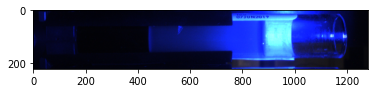

In [3]:
image_array=sitk.ReadImage(os.path.join(image_path,train[0]))           #reads the image
image = sitk.GetArrayFromImage(image_array)
plt.imshow(image)
plt.show()

In [4]:
image.shape

(224, 1280, 3)

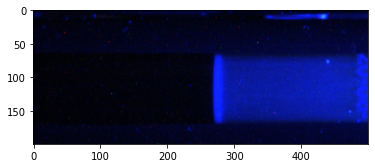

In [5]:
def crop(img):
    crop_img = img[0:200,200:700]
    return crop_img

image = sitk.ReadImage(os.path.join(image_path,train[85]))
image = sitk.GetArrayFromImage(image)
image1 = crop(image)
plt.imshow(image1)

In [6]:
data=[]
with open('images.csv', 'w', newline='') as writeFile:
    writer = csv.writer(writeFile)
    for filename in os.listdir(image_path):
        data.append(filename)
        writer.writerow(data)
        data=[]
writeFile.close()

In [7]:
df = pd.read_csv('images.csv',names = ['View name','type'],sep='.')
df.head()

View name type
0   1 _BloodIQ_Lane[1]_1 _00299  png
1   1 _BloodIQ_Lane[1]_1 _00914  png
2  1 _BloodIQ_Lane[1]_10 _00749  png
3  1 _BloodIQ_Lane[1]_10 _00941  png
4   1 _BloodIQ_Lane[1]_2 _00300  png

In [8]:
print(len(df['View name']))

618


In [9]:
def loadData(image_path,ground_path,image_size,df):
    
    X1, y1 = [], []
    
    for i, item in df.iterrows():
        
        img = sitk.ReadImage(image_path + item[0]+'.png')
        img = sitk.GetArrayFromImage(img)/255.0
        img = crop(img)
        img = cv.resize(img,(image_size,image_size))
        
        
        mask = sitk.ReadImage(ground_path + item[0]+'_0_region.png')
        mask = sitk.GetArrayFromImage(mask)/255.0
        mask = crop(mask)
        
        mask = cv.resize(mask,(image_size,image_size))
        mask = rgb2gray(mask)
            
        X1.append(img)                                         
        y1.append(mask)                                        
            
    X1 = np.array(X1)
    y1 = np.array(y1)
    
    return X1,y1

In [10]:
X,y = loadData(image_path,ground_path,image_size=224,df=df)

In [11]:
y = np.expand_dims(y,axis=-1)

In [12]:
X.shape

(618, 224, 224, 3)

In [13]:
y.shape

(618, 224, 224, 1)

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

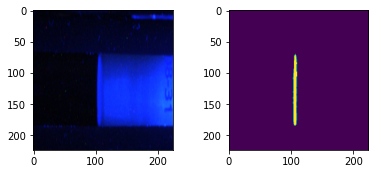

In [15]:
r = random.randint(0, len(X_train)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(X_train[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(y_train[r])

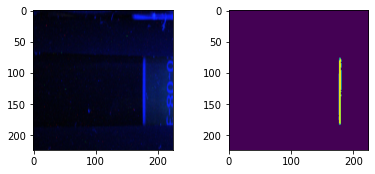

In [16]:
r = random.randint(0, len(X_train)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(X_train[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(y_train[r])

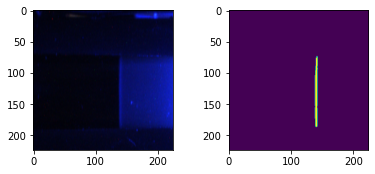

In [17]:
r = random.randint(0, len(X_train)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(X_train[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(y_train[r])

In [21]:
image_size=224
arch = ResUnetPlusPlus(input_size=image_size)
model = arch.build_model()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 224, 224, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 224, 224, 32) 128         conv2d_41[0][0]                  
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 224, 224, 32) 0           batch_normalization_37[0][0]     
_______________________________________________________________________________________

In [22]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [23]:
metrics = [dice_coef, Recall(), Precision()]

lr = 1e-4
optimizer = Nadam(learning_rate=lr)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=metrics,
)

In [25]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    EarlyStopping(monitor='val_loss', patience=20),
    ModelCheckpoint('Unet_3.h5', monitor='val_loss', verbose=1,save_best_only=True, mode = 'auto')
]

In [26]:
BATCH=4

train_steps = len(X_train)//BATCH
valid_steps = len(X_test)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_test) % BATCH != 0:
    valid_steps += 1

In [27]:
model.fit(
   X_train,y_train,
   steps_per_epoch=train_steps,
    validation_steps=valid_steps,
   epochs = 100,
   validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/100
124/124 [==============================] - ETA: 0s - loss: 0.5993 - dice_coef: 0.0394 - recall_1: 0.9419 - precision_1: 0.0687
Epoch 00001: val_loss improved from inf to 0.48097, saving model to Unet_3.h5
124/124 [==============================] - 34s 275ms/step - loss: 0.5993 - dice_coef: 0.0394 - recall_1: 0.9419 - precision_1: 0.0687 - val_loss: 0.4810 - val_dice_coef: 0.0203 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/100
124/124 [==============================] - ETA: 0s - loss: 0.2138 - dice_coef: 0.1287 - recall_1: 0.8342 - precision_1: 0.5765
Epoch 00002: val_loss improved from 0.48097 to 0.19357, saving model to Unet_3.h5
124/124 [==============================] - 32s 255ms/step - loss: 0.2138 - dice_coef: 0.1287 - recall_1: 0.8342 - precision_1: 0.5765 - val_loss: 0.1936 - val_dice_coef: 0.0167 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/100
124/124 [==============================] - ETA: 0s - loss: 0.0906 - dice_coef: 0.2

124/124 [==============================] - ETA: 0s - loss: 0.0104 - dice_coef: 0.7423 - recall_1: 0.8183 - precision_1: 0.9688
Epoch 00020: val_loss did not improve from 0.02251
124/124 [==============================] - 32s 260ms/step - loss: 0.0104 - dice_coef: 0.7423 - recall_1: 0.8183 - precision_1: 0.9688 - val_loss: 0.2022 - val_dice_coef: 0.6994 - val_recall_1: 0.8006 - val_precision_1: 0.8146
Epoch 21/100
124/124 [==============================] - ETA: 0s - loss: 0.0109 - dice_coef: 0.7367 - recall_1: 0.8112 - precision_1: 0.9696
Epoch 00021: val_loss did not improve from 0.02251
124/124 [==============================] - 32s 261ms/step - loss: 0.0109 - dice_coef: 0.7367 - recall_1: 0.8112 - precision_1: 0.9696 - val_loss: 0.1970 - val_dice_coef: 0.6981 - val_recall_1: 0.8003 - val_precision_1: 0.8146
Epoch 22/100
124/124 [==============================] - ETA: 0s - loss: 0.0121 - dice_coef: 0.7383 - recall_1: 0.8162 - precision_1: 0.9673
Epoch 00022: val_loss did not improve f

In [28]:
lr = 1e-5
optimizer = Nadam(learning_rate=lr)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy',Recall(), Precision()],
)

In [29]:
callbacks2 = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint('Unet_4.h5', monitor='val_loss', verbose=1,save_best_only=True, mode = 'auto')
]

In [30]:
r = model.fit(
   X_train,y_train,
   steps_per_epoch=train_steps,
    validation_steps=valid_steps,
   epochs = 50,
   validation_data=(X_test, y_test),
    callbacks = callbacks2
)

Epoch 1/50
124/124 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9967 - recall_2: 0.8188 - precision_2: 0.9676
Epoch 00001: val_loss improved from inf to 0.32135, saving model to Unet_4.h5
124/124 [==============================] - 34s 273ms/step - loss: 0.0115 - accuracy: 0.9967 - recall_2: 0.8188 - precision_2: 0.9676 - val_loss: 0.3214 - val_accuracy: 0.9936 - val_recall_2: 0.8032 - val_precision_2: 0.7353
Epoch 2/50
124/124 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9967 - recall_2: 0.8206 - precision_2: 0.9660
Epoch 00002: val_loss improved from 0.32135 to 0.05573, saving model to Unet_4.h5
124/124 [==============================] - 34s 274ms/step - loss: 0.0096 - accuracy: 0.9967 - recall_2: 0.8206 - precision_2: 0.9660 - val_loss: 0.0557 - val_accuracy: 0.9955 - val_recall_2: 0.7871 - val_precision_2: 0.8776
Epoch 3/50
124/124 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.9968 - recall_2: 0.8247 - p

124/124 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9969 - recall_2: 0.8465 - precision_2: 0.9696
Epoch 00020: val_loss did not improve from 0.00592
124/124 [==============================] - 32s 261ms/step - loss: 0.0058 - accuracy: 0.9969 - recall_2: 0.8465 - precision_2: 0.9696 - val_loss: 0.0070 - val_accuracy: 0.9966 - val_recall_2: 0.8320 - val_precision_2: 0.9578
Epoch 21/50
124/124 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9969 - recall_2: 0.8447 - precision_2: 0.9724
Epoch 00021: val_loss did not improve from 0.00592
124/124 [==============================] - 33s 262ms/step - loss: 0.0061 - accuracy: 0.9969 - recall_2: 0.8447 - precision_2: 0.9724 - val_loss: 0.0064 - val_accuracy: 0.9967 - val_recall_2: 0.8242 - val_precision_2: 0.9664
Epoch 22/50
124/124 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9970 - recall_2: 0.8508 - precision_2: 0.9739
Epoch 00022: val_loss did not improve from 0.005

In [15]:
final_model = tf.keras.models.load_model('Unet_4.h5')

(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_1 _00299_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_1 _00914_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_10 _00749_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_10 _00941_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_2 _00300_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_2 _00725_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)

C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_2 _00917_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_3 _00301_output.png is a low contrast image



(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_4 _00302_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_4 _00731_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_4 _00923_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_6 _00304_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_6 _00737_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_6 _00929_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_7 _00305_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_7 _00932_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_8 _00306_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_8 _00743_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_9 _00307_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1 _BloodIQ_Lane[1]_9 _00938_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202001_Blue_Lane [1]_RackIndex[1]_Date_01_09_2020_ 0530_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202001_Blue_Lane [5]_RackIndex[15]_Date_01_23_2020_ 1614_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202002_Blue_Lane [1]_RackIndex[2]_Date_01_09_2020_ 0532_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202002_Blue_Lane [5]_RackIndex[14]_Date_01_23_2020_ 1612_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202003_Blue_Lane [1]_RackIndex[3]_Date_01_09_2020_ 0534_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202003_Blue_Lane [5]_RackIndex[11]_Date_01_23_2020_ 1606_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202004_Blue_Lane [5]_RackIndex[10]_Date_01_23_2020_ 1604_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202005_Blue_Lane [1]_RackIndex[5]_Date_01_09_2020_ 0538_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202005_Blue_Lane [4]_RackIndex[15]_Date_01_23_2020_ 1582_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202006_Blue_Lane [1]_RackIndex[6]_Date_01_09_2020_ 0540_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202006_Blue_Lane [4]_RackIndex[14]_Date_01_23_2020_ 1580_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202007_Blue_Lane [1]_RackIndex[7]_Date_01_09_2020_ 0542_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202008_Blue_Lane [1]_RackIndex[8]_Date_01_09_2020_ 0544_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202009_Blue_Lane [1]_RackIndex[9]_Date_01_09_2020_ 0546_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202009_Blue_Lane [5]_RackIndex[12]_Date_01_23_2020_ 1608_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202010_Blue_Lane [1]_RackIndex[10]_Date_01_09_2020_ 0548_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202010_Blue_Lane [5]_RackIndex[9]_Date_01_23_2020_ 1602_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202011_Blue_Lane [1]_RackIndex[11]_Date_01_09_2020_ 0550_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202011_Blue_Lane [5]_RackIndex[5]_Date_01_23_2020_ 1594_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202012_Blue_Lane [1]_RackIndex[12]_Date_01_09_2020_ 0552_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202012_Blue_Lane [5]_RackIndex[1]_Date_01_23_2020_ 1586_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202013_Blue_Lane [1]_RackIndex[13]_Date_01_09_2020_ 0554_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202014_Blue_Lane [1]_RackIndex[14]_Date_01_09_2020_ 0556_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202015_Blue_Lane [1]_RackIndex[15]_Date_01_09_2020_ 0558_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202015_Blue_Lane [5]_RackIndex[13]_Date_01_23_2020_ 1610_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202016_Blue_Lane [1]_RackIndex[16]_Date_01_09_2020_ 0560_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202016_Blue_Lane [5]_RackIndex[8]_Date_01_23_2020_ 1600_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202017_Blue_Lane [2]_RackIndex[1]_Date_01_09_2020_ 0562_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202017_Blue_Lane [5]_RackIndex[4]_Date_01_23_2020_ 1592_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202018_Blue_Lane [2]_RackIndex[2]_Date_01_09_2020_ 0564_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202018_Blue_Lane [4]_RackIndex[16]_Date_01_23_2020_ 1584_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202019_Blue_Lane [2]_RackIndex[3]_Date_01_09_2020_ 0566_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202020_Blue_Lane [2]_RackIndex[4]_Date_01_09_2020_ 0568_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202020_Blue_Lane [5]_RackIndex[16]_Date_01_23_2020_ 1616_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202021_Blue_Lane [5]_RackIndex[7]_Date_01_23_2020_ 1598_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202022_Blue_Lane [2]_RackIndex[6]_Date_01_09_2020_ 0572_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202022_Blue_Lane [5]_RackIndex[6]_Date_01_23_2020_ 1596_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202023_Blue_Lane [2]_RackIndex[7]_Date_01_09_2020_ 0574_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202023_Blue_Lane [5]_RackIndex[3]_Date_01_23_2020_ 1590_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202024_Blue_Lane [2]_RackIndex[8]_Date_01_09_2020_ 0576_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202024_Blue_Lane [5]_RackIndex[2]_Date_01_23_2020_ 1588_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202025_Blue_Lane [1]_RackIndex[1]_Date_01_10_2020_ 0626_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202025_Blue_Lane [1]_RackIndex[1]_Date_01_10_2020_ 0722_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202025_Blue_Lane [1]_RackIndex[1]_Date_01_10_2020_ 0818_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202025_Blue_Lane [1]_RackIndex[1]_Date_01_10_2020_ 0914_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202025_Blue_Lane [2]_RackIndex[9]_Date_01_09_2020_ 0578_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202025_Blue_Lane [4]_RackIndex[1]_Date_01_10_2020_ 0978_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202025_Blue_Lane [4]_RackIndex[1]_Date_01_10_2020_ 1074_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202025_Blue_Lane [4]_RackIndex[1]_Date_01_10_2020_ 1170_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202026_Blue_Lane [1]_RackIndex[2]_Date_01_10_2020_ 0628_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202026_Blue_Lane [1]_RackIndex[2]_Date_01_10_2020_ 0724_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202026_Blue_Lane [1]_RackIndex[2]_Date_01_10_2020_ 0820_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202026_Blue_Lane [1]_RackIndex[2]_Date_01_10_2020_ 0916_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202026_Blue_Lane [1]_RackIndex[5]_Date_01_10_2020_ 1242_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202026_Blue_Lane [2]_RackIndex[10]_Date_01_09_2020_ 0580_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202026_Blue_Lane [4]_RackIndex[2]_Date_01_10_2020_ 0980_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202026_Blue_Lane [4]_RackIndex[2]_Date_01_10_2020_ 1076_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202026_Blue_Lane [4]_RackIndex[2]_Date_01_10_2020_ 1172_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202027_Blue_Lane [1]_RackIndex[3]_Date_01_10_2020_ 0630_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202027_Blue_Lane [1]_RackIndex[3]_Date_01_10_2020_ 0726_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202027_Blue_Lane [1]_RackIndex[3]_Date_01_10_2020_ 0822_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202027_Blue_Lane [1]_RackIndex[3]_Date_01_10_2020_ 0918_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202027_Blue_Lane [2]_RackIndex[11]_Date_01_09_2020_ 0582_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202027_Blue_Lane [2]_RackIndex[14]_Date_01_10_2020_ 1292_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202027_Blue_Lane [4]_RackIndex[3]_Date_01_10_2020_ 0982_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202027_Blue_Lane [4]_RackIndex[3]_Date_01_10_2020_ 1078_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202027_Blue_Lane [4]_RackIndex[3]_Date_01_10_2020_ 1174_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202027_Blue_Lane [6]_RackIndex[3]_Date_01_23_2020_ 1622_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202028_Blue_Lane [1]_RackIndex[4]_Date_01_10_2020_ 0632_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202028_Blue_Lane [1]_RackIndex[4]_Date_01_10_2020_ 0728_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202028_Blue_Lane [1]_RackIndex[4]_Date_01_10_2020_ 0824_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202028_Blue_Lane [1]_RackIndex[4]_Date_01_10_2020_ 0920_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202028_Blue_Lane [2]_RackIndex[12]_Date_01_09_2020_ 0584_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202028_Blue_Lane [2]_RackIndex[13]_Date_01_10_2020_ 1290_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202028_Blue_Lane [4]_RackIndex[4]_Date_01_10_2020_ 0984_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202028_Blue_Lane [4]_RackIndex[4]_Date_01_10_2020_ 1080_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202028_Blue_Lane [4]_RackIndex[4]_Date_01_10_2020_ 1176_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202028_Blue_Lane [6]_RackIndex[8]_Date_01_23_2020_ 1632_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202029_Blue_Lane [1]_RackIndex[14]_Date_01_10_2020_ 1260_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202029_Blue_Lane [1]_RackIndex[5]_Date_01_10_2020_ 0634_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202029_Blue_Lane [1]_RackIndex[5]_Date_01_10_2020_ 0730_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202029_Blue_Lane [1]_RackIndex[5]_Date_01_10_2020_ 0826_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202029_Blue_Lane [1]_RackIndex[5]_Date_01_10_2020_ 0922_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202029_Blue_Lane [2]_RackIndex[13]_Date_01_09_2020_ 0586_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202029_Blue_Lane [4]_RackIndex[5]_Date_01_10_2020_ 0986_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202029_Blue_Lane [4]_RackIndex[5]_Date_01_10_2020_ 1082_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202029_Blue_Lane [4]_RackIndex[5]_Date_01_10_2020_ 1178_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202030_Blue_Lane [1]_RackIndex[11]_Date_01_10_2020_ 1254_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202030_Blue_Lane [1]_RackIndex[6]_Date_01_10_2020_ 0636_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202030_Blue_Lane [1]_RackIndex[6]_Date_01_10_2020_ 0732_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202030_Blue_Lane [1]_RackIndex[6]_Date_01_10_2020_ 0828_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202030_Blue_Lane [1]_RackIndex[6]_Date_01_10_2020_ 0924_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202030_Blue_Lane [2]_RackIndex[14]_Date_01_09_2020_ 0588_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202030_Blue_Lane [4]_RackIndex[6]_Date_01_10_2020_ 0988_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202030_Blue_Lane [4]_RackIndex[6]_Date_01_10_2020_ 1084_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202030_Blue_Lane [4]_RackIndex[6]_Date_01_10_2020_ 1180_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202031_Blue_Lane [1]_RackIndex[1]_Date_01_10_2020_ 1234_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202031_Blue_Lane [1]_RackIndex[7]_Date_01_10_2020_ 0638_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202031_Blue_Lane [1]_RackIndex[7]_Date_01_10_2020_ 0734_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202031_Blue_Lane [1]_RackIndex[7]_Date_01_10_2020_ 0830_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1001092

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)

C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202031_Blue_Lane [2]_RackIndex[15]_Date_01_09_2020_ 0590_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202031_Blue_Lane [4]_RackIndex[7]_Date_01_10_2020_ 0990_output.png is a low contrast image



(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202031_Blue_Lane [4]_RackIndex[7]_Date_01_10_2020_ 1086_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202031_Blue_Lane [4]_RackIndex[7]_Date_01_10_2020_ 1182_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202032_Blue_Lane [1]_RackIndex[8]_Date_01_10_2020_ 0640_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202032_Blue_Lane [1]_RackIndex[8]_Date_01_10_2020_ 0736_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202032_Blue_Lane [1]_RackIndex[8]_Date_01_10_2020_ 0832_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202032_Blue_Lane [1]_RackIndex[8]_Date_01_10_2020_ 0928_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202032_Blue_Lane [3]_RackIndex[2]_Date_01_10_2020_ 1300_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202032_Blue_Lane [4]_RackIndex[8]_Date_01_10_2020_ 0992_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202032_Blue_Lane [4]_RackIndex[8]_Date_01_10_2020_ 1088_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202032_Blue_Lane [4]_RackIndex[8]_Date_01_10_2020_ 1184_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202033_Blue_Lane [1]_RackIndex[9]_Date_01_10_2020_ 0642_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202033_Blue_Lane [1]_RackIndex[9]_Date_01_10_2020_ 0738_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)

C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202033_Blue_Lane [1]_RackIndex[9]_Date_01_10_2020_ 0834_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202033_Blue_Lane [1]_RackIndex[9]_Date_01_10_2020_ 0930_output.png is a low contrast image



(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202033_Blue_Lane [2]_RackIndex[15]_Date_01_10_2020_ 1294_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202033_Blue_Lane [3]_RackIndex[1]_Date_01_09_2020_ 0594_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202033_Blue_Lane [4]_RackIndex[9]_Date_01_10_2020_ 0994_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202033_Blue_Lane [4]_RackIndex[9]_Date_01_10_2020_ 1090_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202033_Blue_Lane [4]_RackIndex[9]_Date_01_10_2020_ 1186_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202033_Blue_Lane [6]_RackIndex[14]_Date_01_23_2020_ 1644_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202034_Blue_Lane [1]_RackIndex[10]_Date_01_10_2020_ 0644_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202034_Blue_Lane [1]_RackIndex[10]_Date_01_10_2020_ 0740_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202034_Blue_Lane [1]_RackIndex[10]_Date_01_10_2020_ 0836_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202034_Blue_Lane [1]_RackIndex[10]_Date_01_10_2020_ 0932_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202034_Blue_Lane [3]_RackIndex[2]_Date_01_09_2020_ 0596_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202034_Blue_Lane [4]_RackIndex[10]_Date_01_10_2020_ 0996_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202034_Blue_Lane [4]_RackIndex[10]_Date_01_10_2020_ 1092_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202034_Blue_Lane [4]_RackIndex[10]_Date_01_10_2020_ 1188_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202035_Blue_Lane [1]_RackIndex[11]_Date_01_10_2020_ 0646_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202035_Blue_Lane [1]_RackIndex[11]_Date_01_10_2020_ 0742_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202035_Blue_Lane [1]_RackIndex[11]_Date_01_10_2020_ 0838_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202035_Blue_Lane [1]_RackIndex[11]_Date_01_10_2020_ 0934_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202035_Blue_Lane [2]_RackIndex[9]_Date_01_10_2020_ 1282_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202035_Blue_Lane [4]_RackIndex[11]_Date_01_10_2020_ 0998_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202035_Blue_Lane [4]_RackIndex[11]_Date_01_10_2020_ 1094_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202035_Blue_Lane [4]_RackIndex[11]_Date_01_10_2020_ 1190_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1001

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202036_Blue_Lane [1]_RackIndex[12]_Date_01_10_2020_ 0744_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202036_Blue_Lane [1]_RackIndex[12]_Date_01_10_2020_ 0840_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202036_Blue_Lane [1]_RackIndex[12]_Date_01_10_2020_ 0936_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202036_Blue_Lane [2]_RackIndex[2]_Date_01_10_2020_ 1268_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202036_Blue_Lane [4]_RackIndex[12]_Date_01_10_2020_ 1000_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202036_Blue_Lane [4]_RackIndex[12]_Date_01_10_2020_ 1096_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202036_Blue_Lane [4]_RackIndex[12]_Date_01_10_2020_ 1192_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202037_Blue_Lane [1]_RackIndex[13]_Date_01_10_2020_ 0650_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202037_Blue_Lane [1]_RackIndex[13]_Date_01_10_2020_ 0746_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202037_Blue_Lane [1]_RackIndex[13]_Date_01_10_2020_ 0842_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202037_Blue_Lane [1]_RackIndex[13]_Date_01_10_2020_ 0938_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202037_Blue_Lane [3]_RackIndex[3]_Date_01_10_2020_ 1302_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202037_Blue_Lane [4]_RackIndex[13]_Date_01_10_2020_ 1002_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202037_Blue_Lane [4]_RackIndex[13]_Date_01_10_2020_ 1098_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202037_Blue_Lane [4]_RackIndex[13]_Date_01_10_2020_ 1194_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202037_Blue_Lane [6]_RackIndex[7]_Date_01_23_2020_ 1630_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202038_Blue_Lane [1]_RackIndex[14]_Date_01_10_2020_ 0652_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202038_Blue_Lane [1]_RackIndex[14]_Date_01_10_2020_ 0748_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202038_Blue_Lane [1]_RackIndex[14]_Date_01_10_2020_ 0844_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202038_Blue_Lane [1]_RackIndex[14]_Date_01_10_2020_ 0940_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202038_Blue_Lane [3]_RackIndex[1]_Date_01_10_2020_ 1298_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202038_Blue_Lane [4]_RackIndex[14]_Date_01_10_2020_ 1004_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202038_Blue_Lane [4]_RackIndex[14]_Date_01_10_2020_ 1100_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202038_Blue_Lane [4]_RackIndex[14]_Date_01_10_2020_ 1196_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202039_Blue_Lane [1]_RackIndex[15]_Date_01_10_2020_ 0654_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202039_Blue_Lane [1]_RackIndex[15]_Date_01_10_2020_ 0750_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202039_Blue_Lane [1]_RackIndex[15]_Date_01_10_2020_ 0846_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202039_Blue_Lane [1]_RackIndex[15]_Date_01_10_2020_ 0942_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202039_Blue_Lane [2]_RackIndex[10]_Date_01_10_2020_ 1284_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202039_Blue_Lane [4]_RackIndex[15]_Date_01_10_2020_ 1006_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202039_Blue_Lane [4]_RackIndex[15]_Date_01_10_2020_ 1102_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202039_Blue_Lane [4]_RackIndex[15]_Date_01_10_2020_ 1198_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202040_Blue_Lane [1]_RackIndex[16]_Date_01_10_2020_ 0656_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202040_Blue_Lane [1]_RackIndex[16]_Date_01_10_2020_ 0752_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202040_Blue_Lane [1]_RackIndex[16]_Date_01_10_2020_ 0848_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202040_Blue_Lane [1]_RackIndex[16]_Date_01_10_2020_ 0944_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202040_Blue_Lane [2]_RackIndex[1]_Date_01_10_2020_ 1266_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202040_Blue_Lane [4]_RackIndex[16]_Date_01_10_2020_ 1008_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202040_Blue_Lane [4]_RackIndex[16]_Date_01_10_2020_ 1104_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202040_Blue_Lane [4]_RackIndex[16]_Date_01_10_2020_ 1200_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202041_Blue_Lane [1]_RackIndex[6]_Date_01_10_2020_ 1244_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202041_Blue_Lane [2]_RackIndex[1]_Date_01_10_2020_ 0658_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202041_Blue_Lane [2]_RackIndex[1]_Date_01_10_2020_ 0754_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202041_Blue_Lane [2]_RackIndex[1]_Date_01_10_2020_ 0850_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202041_Blue_Lane [3]_RackIndex[1]_Date_01_10_2020_ 0946_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202041_Blue_Lane [3]_RackIndex[1]_Date_01_10_2020_ 1042_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202041_Blue_Lane [3]_RackIndex[1]_Date_01_10_2020_ 1138_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202042_Blue_Lane [2]_RackIndex[2]_Date_01_10_2020_ 0660_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202042_Blue_Lane [2]_RackIndex[2]_Date_01_10_2020_ 0756_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202042_Blue_Lane [2]_RackIndex[2]_Date_01_10_2020_ 0852_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202042_Blue_Lane [2]_RackIndex[6]_Date_01_10_2020_ 1276_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202042_Blue_Lane [3]_RackIndex[2]_Date_01_10_2020_ 0948_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202042_Blue_Lane [3]_RackIndex[2]_Date_01_10_2020_ 1044_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202042_Blue_Lane [3]_RackIndex[2]_Date_01_10_2020_ 1140_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202043_Blue_Lane [2]_RackIndex[11]_Date_01_10_2020_ 1286_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202043_Blue_Lane [2]_RackIndex[3]_Date_01_10_2020_ 0662_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202043_Blue_Lane [2]_RackIndex[3]_Date_01_10_2020_ 0758_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202043_Blue_Lane [2]_RackIndex[3]_Date_01_10_2020_ 0854_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202043_Blue_Lane [3]_RackIndex[3]_Date_01_10_2020_ 0950_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202043_Blue_Lane [3]_RackIndex[3]_Date_01_10_2020_ 1046_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202043_Blue_Lane [3]_RackIndex[3]_Date_01_10_2020_ 1142_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202044_Blue_Lane [2]_RackIndex[16]_Date_01_10_2020_ 1296_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202044_Blue_Lane [2]_RackIndex[4]_Date_01_10_2020_ 0664_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202044_Blue_Lane [2]_RackIndex[4]_Date_01_10_2020_ 0760_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202044_Blue_Lane [2]_RackIndex[4]_Date_01_10_2020_ 0856_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202044_Blue_Lane [3]_RackIndex[4]_Date_01_10_2020_ 0952_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202044_Blue_Lane [3]_RackIndex[4]_Date_01_10_2020_ 1048_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202044_Blue_Lane [3]_RackIndex[4]_Date_01_10_2020_ 1144_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202045_Blue_Lane [1]_RackIndex[12]_Date_01_10_2020_ 1256_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202045_Blue_Lane [2]_RackIndex[5]_Date_01_10_2020_ 0666_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202045_Blue_Lane [2]_RackIndex[5]_Date_01_10_2020_ 0762_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202045_Blue_Lane [2]_RackIndex[5]_Date_01_10_2020_ 0858_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202045_Blue_Lane [3]_RackIndex[5]_Date_01_10_2020_ 0954_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202045_Blue_Lane [3]_RackIndex[5]_Date_01_10_2020_ 1050_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202045_Blue_Lane [3]_RackIndex[5]_Date_01_10_2020_ 1146_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202046_Blue_Lane [1]_RackIndex[15]_Date_01_10_2020_ 1262_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202046_Blue_Lane [2]_RackIndex[6]_Date_01_10_2020_ 0668_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202046_Blue_Lane [2]_RackIndex[6]_Date_01_10_2020_ 0764_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202046_Blue_Lane [2]_RackIndex[6]_Date_01_10_2020_ 0860_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202046_Blue_Lane [3]_RackIndex[6]_Date_01_10_2020_ 0956_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202046_Blue_Lane [3]_RackIndex[6]_Date_01_10_2020_ 1052_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202046_Blue_Lane [3]_RackIndex[6]_Date_01_10_2020_ 1148_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202047_Blue_Lane [2]_RackIndex[7]_Date_01_10_2020_ 0670_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202047_Blue_Lane [2]_RackIndex[7]_Date_01_10_2020_ 0766_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202047_Blue_Lane [2]_RackIndex[7]_Date_01_10_2020_ 0862_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202047_Blue_Lane [2]_RackIndex[7]_Date_01_10_2020_ 1278_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202047_Blue_Lane [3]_RackIndex[7]_Date_01_10_2020_ 0958_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202047_Blue_Lane [3]_RackIndex[7]_Date_01_10_2020_ 1054_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202047_Blue_Lane [3]_RackIndex[7]_Date_01_10_2020_ 1150_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202048_Blue_Lane [1]_RackIndex[10]_Date_01_10_2020_ 1252_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202048_Blue_Lane [2]_RackIndex[8]_Date_01_10_2020_ 0672_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202048_Blue_Lane [2]_RackIndex[8]_Date_01_10_2020_ 0768_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202048_Blue_Lane [2]_RackIndex[8]_Date_01_10_2020_ 0864_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202048_Blue_Lane [3]_RackIndex[8]_Date_01_10_2020_ 0960_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202048_Blue_Lane [3]_RackIndex[8]_Date_01_10_2020_ 1056_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202048_Blue_Lane [3]_RackIndex[8]_Date_01_10_2020_ 1152_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202049_Blue_Lane [1]_RackIndex[2]_Date_01_10_2020_ 1236_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202049_Blue_Lane [2]_RackIndex[9]_Date_01_10_2020_ 0674_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202049_Blue_Lane [2]_RackIndex[9]_Date_01_10_2020_ 0770_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202049_Blue_Lane [2]_RackIndex[9]_Date_01_10_2020_ 0866_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202049_Blue_Lane [3]_RackIndex[9]_Date_01_10_2020_ 1058_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202049_Blue_Lane [3]_RackIndex[9]_Date_01_10_2020_ 1154_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202050_Blue_Lane [1]_RackIndex[9]_Date_01_10_2020_ 1250_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202050_Blue_Lane [2]_RackIndex[10]_Date_01_10_2020_ 0676_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202050_Blue_Lane [2]_RackIndex[10]_Date_01_10_2020_ 0772_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202050_Blue_Lane [2]_RackIndex[10]_Date_01_10_2020_ 0868_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202050_Blue_Lane [3]_RackIndex[10]_Date_01_10_2020_ 0964_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202050_Blue_Lane [3]_RackIndex[10]_Date_01_10_2020_ 1060_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202050_Blue_Lane [3]_RackIndex[10]_Date_01_10_2020_ 1156_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202051_Blue_Lane [1]_RackIndex[16]_Date_01_10_2020_ 1264_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202051_Blue_Lane [2]_RackIndex[11]_Date_01_10_2020_ 0678_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202051_Blue_Lane [2]_RackIndex[11]_Date_01_10_2020_ 0774_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202051_Blue_Lane [2]_RackIndex[11]_Date_01_10_2020_ 0870_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202051_Blue_Lane [3]_RackIndex[11]_Date_01_10_2020_ 0966_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202051_Blue_Lane [3]_RackIndex[11]_Date_01_10_2020_ 1062_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202051_Blue_Lane [3]_RackIndex[11]_Date_01_10_2020_ 1158_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202052_Blue_Lane [2]_RackIndex[12]_Date_01_10_2020_ 0680_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202052_Blue_Lane [2]_RackIndex[12]_Date_01_10_2020_ 0776_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202052_Blue_Lane [2]_RackIndex[12]_Date_01_10_2020_ 0872_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202052_Blue_Lane [2]_RackIndex[4]_Date_01_10_2020_ 1272_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202052_Blue_Lane [3]_RackIndex[12]_Date_01_10_2020_ 0968_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202052_Blue_Lane [3]_RackIndex[12]_Date_01_10_2020_ 1064_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202052_Blue_Lane [3]_RackIndex[12]_Date_01_10_2020_ 1160_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202053_Blue_Lane [1]_RackIndex[3]_Date_01_10_2020_ 1238_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202053_Blue_Lane [2]_RackIndex[13]_Date_01_10_2020_ 0682_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202053_Blue_Lane [2]_RackIndex[13]_Date_01_10_2020_ 0778_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202053_Blue_Lane [2]_RackIndex[13]_Date_01_10_2020_ 0874_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202053_Blue_Lane [3]_RackIndex[13]_Date_01_10_2020_ 0970_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202053_Blue_Lane [3]_RackIndex[13]_Date_01_10_2020_ 1066_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202053_Blue_Lane [3]_RackIndex[13]_Date_01_10_2020_ 1162_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202054_Blue_Lane [1]_RackIndex[13]_Date_01_10_2020_ 1258_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202054_Blue_Lane [2]_RackIndex[14]_Date_01_10_2020_ 0684_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202054_Blue_Lane [2]_RackIndex[14]_Date_01_10_2020_ 0876_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202054_Blue_Lane [3]_RackIndex[14]_Date_01_10_2020_ 0972_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202054_Blue_Lane [3]_RackIndex[14]_Date_01_10_2020_ 1068_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202054_Blue_Lane [3]_RackIndex[14]_Date_01_10_2020_ 1164_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202055_Blue_Lane [2]_RackIndex[15]_Date_01_10_2020_ 0686_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202055_Blue_Lane [2]_RackIndex[15]_Date_01_10_2020_ 0782_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202055_Blue_Lane [2]_RackIndex[15]_Date_01_10_2020_ 0878_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202055_Blue_Lane [2]_RackIndex[5]_Date_01_10_2020_ 1274_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202055_Blue_Lane [3]_RackIndex[15]_Date_01_10_2020_ 0974_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202055_Blue_Lane [3]_RackIndex[15]_Date_01_10_2020_ 1070_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202055_Blue_Lane [3]_RackIndex[15]_Date_01_10_2020_ 1166_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202056_Blue_Lane [2]_RackIndex[16]_Date_01_10_2020_ 0688_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202056_Blue_Lane [2]_RackIndex[16]_Date_01_10_2020_ 0784_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202056_Blue_Lane [2]_RackIndex[16]_Date_01_10_2020_ 0880_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202056_Blue_Lane [2]_RackIndex[3]_Date_01_10_2020_ 1270_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202056_Blue_Lane [3]_RackIndex[16]_Date_01_10_2020_ 0976_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202056_Blue_Lane [3]_RackIndex[16]_Date_01_10_2020_ 1072_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202056_Blue_Lane [3]_RackIndex[16]_Date_01_10_2020_ 1168_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202057_Blue_Lane [1]_RackIndex[8]_Date_01_10_2020_ 1248_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)

C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202057_Blue_Lane [3]_RackIndex[1]_Date_01_10_2020_ 0690_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202057_Blue_Lane [3]_RackIndex[1]_Date_01_10_2020_ 0786_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202057_Blue_Lane [3]_RackIndex[1]_Date_01_10_2020_ 0882_output.png is a low contrast image



(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202057_Blue_Lane [5]_RackIndex[1]_Date_01_10_2020_ 1010_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202057_Blue_Lane [5]_RackIndex[1]_Date_01_10_2020_ 1106_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202057_Blue_Lane [5]_RackIndex[1]_Date_01_10_2020_ 1202_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202058_Blue_Lane [2]_RackIndex[8]_Date_01_10_2020_ 1280_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202058_Blue_Lane [3]_RackIndex[2]_Date_01_10_2020_ 0692_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202058_Blue_Lane [3]_RackIndex[2]_Date_01_10_2020_ 0788_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202058_Blue_Lane [3]_RackIndex[2]_Date_01_10_2020_ 0884_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202058_Blue_Lane [5]_RackIndex[2]_Date_01_10_2020_ 1012_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202058_Blue_Lane [5]_RackIndex[2]_Date_01_10_2020_ 1108_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202058_Blue_Lane [5]_RackIndex[2]_Date_01_10_2020_ 1204_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202059_Blue_Lane [1]_RackIndex[7]_Date_01_10_2020_ 1246_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202059_Blue_Lane [3]_RackIndex[3]_Date_01_10_2020_ 0694_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202059_Blue_Lane [3]_RackIndex[3]_Date_01_10_2020_ 0790_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202059_Blue_Lane [3]_RackIndex[3]_Date_01_10_2020_ 0886_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202059_Blue_Lane [5]_RackIndex[3]_Date_01_10_2020_ 1014_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202059_Blue_Lane [5]_RackIndex[3]_Date_01_10_2020_ 1110_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100109202059_Blue_Lane [5]_RackIndex[3]_Date_01_10_2020_ 1206_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202001_Blue_Lane [1]_RackIndex[1]_Date_01_15_2020_ 1330_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202001_Blue_Lane [1]_RackIndex[1]_Date_01_15_2020_ 1362_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202001_Blue_Lane [1]_RackIndex[1]_Date_01_15_2020_ 1394_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202001_Blue_Lane [1]_RackIndex[1]_Date_01_15_2020_ 1426_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202001_Blue_Lane [6]_RackIndex[4]_Date_01_23_2020_ 1624_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202002_Blue_Lane [1]_RackIndex[2]_Date_01_15_2020_ 1332_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202002_Blue_Lane [1]_RackIndex[2]_Date_01_15_2020_ 1364_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202002_Blue_Lane [1]_RackIndex[2]_Date_01_15_2020_ 1396_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202002_Blue_Lane [1]_RackIndex[2]_Date_01_15_2020_ 1428_output.png is a low contrast image


(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202002_Blue_Lane [6]_RackIndex[13]_Date_01_23_2020_ 1642_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202003_Blue_Lane [1]_RackIndex[3]_Date_01_15_2020_ 1334_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202003_Blue_Lane [1]_RackIndex[3]_Date_01_15_2020_ 1366_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202003_Blue_Lane [1]_RackIndex[3]_Date_01_15_2020_ 1398_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202003_Blue_Lane [1]_RackIndex[3]_Date_01_15_2020_ 1430_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202003_Blue_Lane [6]_RackIndex[16]_Date_01_23_2020_ 1648_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202004_Blue_Lane [1]_RackIndex[4]_Date_01_15_2020_ 1336_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202004_Blue_Lane [1]_RackIndex[4]_Date_01_15_2020_ 1368_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202004_Blue_Lane [1]_RackIndex[4]_Date_01_15_2020_ 1400_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202004_Blue_Lane [1]_RackIndex[4]_Date_01_15_2020_ 1432_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202004_Blue_Lane [6]_RackIndex[12]_Date_01_23_2020_ 1640_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202005_Blue_Lane [1]_RackIndex[5]_Date_01_15_2020_ 1338_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202005_Blue_Lane [1]_RackIndex[5]_Date_01_15_2020_ 1370_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202005_Blue_Lane [1]_RackIndex[5]_Date_01_15_2020_ 1402_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202005_Blue_Lane [1]_RackIndex[5]_Date_01_15_2020_ 1434_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202005_Blue_Lane [6]_RackIndex[10]_Date_01_23_2020_ 1636_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202006_Blue_Lane [1]_RackIndex[6]_Date_01_15_2020_ 1340_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202006_Blue_Lane [1]_RackIndex[6]_Date_01_15_2020_ 1372_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202006_Blue_Lane [1]_RackIndex[6]_Date_01_15_2020_ 1404_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202006_Blue_Lane [1]_RackIndex[6]_Date_01_15_2020_ 1436_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202006_Blue_Lane [6]_RackIndex[6]_Date_01_23_2020_ 1628_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202007_Blue_Lane [1]_RackIndex[7]_Date_01_15_2020_ 1342_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202007_Blue_Lane [1]_RackIndex[7]_Date_01_15_2020_ 1374_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202007_Blue_Lane [1]_RackIndex[7]_Date_01_15_2020_ 1406_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202007_Blue_Lane [1]_RackIndex[7]_Date_01_15_2020_ 1438_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202007_Blue_Lane [6]_RackIndex[2]_Date_01_23_2020_ 1620_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202008_Blue_Lane [1]_RackIndex[8]_Date_01_15_2020_ 1344_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/1001142

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202008_Blue_Lane [1]_RackIndex[8]_Date_01_15_2020_ 1408_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202008_Blue_Lane [1]_RackIndex[8]_Date_01_15_2020_ 1440_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202009_Blue_Lane [1]_RackIndex[9]_Date_01_15_2020_ 1346_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202009_Blue_Lane [1]_RackIndex[9]_Date_01_15_2020_ 1378_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202009_Blue_Lane [1]_RackIndex[9]_Date_01_15_2020_ 1410_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202009_Blue_Lane [1]_RackIndex[9]_Date_01_15_2020_ 1442_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202009_Blue_Lane [6]_RackIndex[15]_Date_01_23_2020_ 1646_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202010_Blue_Lane [6]_RackIndex[11]_Date_01_23_2020_ 1638_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202011_Blue_Lane [1]_RackIndex[11]_Date_01_15_2020_ 1350_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202011_Blue_Lane [1]_RackIndex[11]_Date_01_15_2020_ 1382_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202011_Blue_Lane [1]_RackIndex[11]_Date_01_15_2020_ 1414_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202011_Blue_Lane [1]_RackIndex[11]_Date_01_15_2020_ 1446_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202011_Blue_Lane [6]_RackIndex[9]_Date_01_23_2020_ 1634_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202012_Blue_Lane [6]_RackIndex[5]_Date_01_23_2020_ 1626_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202013_Blue_Lane [1]_RackIndex[13]_Date_01_15_2020_ 1354_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202013_Blue_Lane [1]_RackIndex[13]_Date_01_15_2020_ 1386_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202013_Blue_Lane [1]_RackIndex[13]_Date_01_15_2020_ 1418_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202013_Blue_Lane [1]_RackIndex[13]_Date_01_15_2020_ 1450_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202013_Blue_Lane [6]_RackIndex[1]_Date_01_23_2020_ 1618_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100114202015_Blue_Lane [2]_RackIndex[8]_Date_01_23_2020_ 1504_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202051_Blue_Lane [2]_RackIndex[14]_Date_01_23_2020_ 1516_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202052_Blue_Lane [2]_RackIndex[15]_Date_01_23_2020_ 1518_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202053_Blue_Lane [3]_RackIndex[1]_Date_01_23_2020_ 1522_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202054_Blue_Lane [3]_RackIndex[2]_Date_01_23_2020_ 1524_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202055_Blue_Lane [2]_RackIndex[7]_Date_01_23_2020_ 1502_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202056_Blue_Lane [2]_RackIndex[6]_Date_01_23_2020_ 1500_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202057_Blue_Lane [2]_RackIndex[11]_Date_01_23_2020_ 1510_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202058_Blue_Lane [2]_RackIndex[13]_Date_01_23_2020_ 1514_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202059_Blue_Lane [2]_RackIndex[16]_Date_01_23_2020_ 1520_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202060_Blue_Lane [3]_RackIndex[3]_Date_01_23_2020_ 1526_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202061_Blue_Lane [2]_RackIndex[5]_Date_01_23_2020_ 1498_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202062_Blue_Lane [2]_RackIndex[4]_Date_01_23_2020_ 1496_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202063_Blue_Lane [2]_RackIndex[10]_Date_01_23_2020_ 1508_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202064_Blue_Lane [2]_RackIndex[12]_Date_01_23_2020_ 1512_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202065_Blue_Lane [3]_RackIndex[5]_Date_01_23_2020_ 1530_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202066_Blue_Lane [3]_RackIndex[4]_Date_01_23_2020_ 1528_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202067_Blue_Lane [2]_RackIndex[3]_Date_01_23_2020_ 1494_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202068_Blue_Lane [2]_RackIndex[2]_Date_01_23_2020_ 1492_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202069_Blue_Lane [2]_RackIndex[1]_Date_01_23_2020_ 1490_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100116202070_Blue_Lane [1]_RackIndex[16]_Date_01_23_2020_ 1488_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202001_Blue_Lane [4]_RackIndex[6]_Date_01_23_2020_ 1564_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202002_Blue_Lane [4]_RackIndex[4]_Date_01_23_2020_ 1560_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202003_Blue_Lane [4]_RackIndex[5]_Date_01_23_2020_ 1562_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202004_Blue_Lane [4]_RackIndex[8]_Date_01_23_2020_ 1568_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202005_Blue_Lane [4]_RackIndex[10]_Date_01_23_2020_ 1572_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202006_Blue_Lane [4]_RackIndex[11]_Date_01_23_2020_ 1574_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202007_Blue_Lane [4]_RackIndex[7]_Date_01_23_2020_ 1566_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202008_Blue_Lane [4]_RackIndex[2]_Date_01_23_2020_ 1556_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202009_Blue_Lane [4]_RackIndex[3]_Date_01_23_2020_ 1558_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202010_Blue_Lane [4]_RackIndex[9]_Date_01_23_2020_ 1570_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202011_Blue_Lane [4]_RackIndex[12]_Date_01_23_2020_ 1576_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202012_Blue_Lane [4]_RackIndex[13]_Date_01_23_2020_ 1578_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202015_Blue_Lane [3]_RackIndex[15]_Date_01_23_2020_ 1550_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202016_Blue_Lane [3]_RackIndex[14]_Date_01_23_2020_ 1548_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202017_Blue_Lane [4]_RackIndex[1]_Date_01_23_2020_ 1554_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202018_Blue_Lane [3]_RackIndex[16]_Date_01_23_2020_ 1552_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202019_Blue_Lane [3]_RackIndex[7]_Date_01_23_2020_ 1534_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202020_Blue_Lane [3]_RackIndex[6]_Date_01_23_2020_ 1532_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202021_Blue_Lane [3]_RackIndex[9]_Date_01_23_2020_ 1538_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202022_Blue_Lane [3]_RackIndex[8]_Date_01_23_2020_ 1536_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100117202023_Blue_Lane [3]_RackIndex[11]_Date_01_23_2020_ 1542_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100122202002_Blue_Lane [1]_RackIndex[13]_Date_01_23_2020_ 1482_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100122202003_Blue_Lane [1]_RackIndex[14]_Date_01_23_2020_ 1484_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100122202005_Blue_Lane [1]_RackIndex[8]_Date_01_23_2020_ 1472_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100122202006_Blue_Lane [1]_RackIndex[11]_Date_01_23_2020_ 1478_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100122202007_Blue_Lane [1]_RackIndex[12]_Date_01_23_2020_ 1480_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100122202008_Blue_Lane [1]_RackIndex[9]_Date_01_23_2020_ 1474_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100122202009_Blue_Lane [1]_RackIndex[10]_Date_01_23_2020_ 1476_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100122202010_Blue_Lane [1]_RackIndex[5]_Date_01_23_2020_ 1466_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100122202011_Blue_Lane [1]_RackIndex[1]_Date_01_23_2020_ 1458_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100122202012_Blue_Lane [1]_RackIndex[2]_Date_01_23_2020_ 1460_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100122202013_Blue_Lane [1]_RackIndex[3]_Date_01_23_2020_ 1462_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100122202014_Blue_Lane [1]_RackIndex[4]_Date_01_23_2020_ 1464_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100122202015_Blue_Lane [1]_RackIndex[6]_Date_01_23_2020_ 1468_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202035_Blue_Lane [2]_RackIndex[8]_Date_02_03_2020_ 0566_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202036_Blue_Lane [2]_RackIndex[7]_Date_02_03_2020_ 0564_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202037_Blue_Lane [2]_RackIndex[6]_Date_02_03_2020_ 0562_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202038_Blue_Lane [2]_RackIndex[5]_Date_02_03_2020_ 0560_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202039_Blue_Lane [2]_RackIndex[4]_Date_02_03_2020_ 0558_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202040_Blue_Lane [2]_RackIndex[3]_Date_02_03_2020_ 0556_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202041_Blue_Lane [2]_RackIndex[2]_Date_02_03_2020_ 0554_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202042_Blue_Lane [2]_RackIndex[1]_Date_02_03_2020_ 0552_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202043_Blue_Lane [1]_RackIndex[16]_Date_02_03_2020_ 0550_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202044_Blue_Lane [1]_RackIndex[15]_Date_02_03_2020_ 0548_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202045_Blue_Lane [1]_RackIndex[14]_Date_02_03_2020_ 0546_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202046_Blue_Lane [1]_RackIndex[13]_Date_02_03_2020_ 0544_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202047_Blue_Lane [1]_RackIndex[12]_Date_02_03_2020_ 0542_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202048_Blue_Lane [1]_RackIndex[11]_Date_02_03_2020_ 0540_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202049_Blue_Lane [1]_RackIndex[10]_Date_02_03_2020_ 0538_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202050_Blue_Lane [1]_RackIndex[9]_Date_02_03_2020_ 0536_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202051_Blue_Lane [1]_RackIndex[8]_Date_02_03_2020_ 0534_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202052_Blue_Lane [1]_RackIndex[7]_Date_02_03_2020_ 0532_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202053_Blue_Lane [1]_RackIndex[6]_Date_02_03_2020_ 0530_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202054_Blue_Lane [1]_RackIndex[5]_Date_02_03_2020_ 0528_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202055_Blue_Lane [1]_RackIndex[4]_Date_02_03_2020_ 0526_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202057_Blue_Lane [1]_RackIndex[2]_Date_02_03_2020_ 0522_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100123202058_Blue_Lane [1]_RackIndex[1]_Date_02_03_2020_ 0520_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202001_Blue_Lane [2]_RackIndex[9]_Date_02_03_2020_ 0568_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202002_Blue_Lane [2]_RackIndex[10]_Date_02_03_2020_ 0570_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202003_Blue_Lane [2]_RackIndex[11]_Date_02_03_2020_ 0572_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202004_Blue_Lane [2]_RackIndex[12]_Date_02_03_2020_ 0574_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202005_Blue_Lane [2]_RackIndex[13]_Date_02_03_2020_ 0576_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202006_Blue_Lane [2]_RackIndex[14]_Date_02_03_2020_ 0578_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202007_Blue_Lane [2]_RackIndex[15]_Date_02_03_2020_ 0580_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202008_Blue_Lane [2]_RackIndex[16]_Date_02_03_2020_ 0582_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202009_Blue_Lane [3]_RackIndex[1]_Date_02_03_2020_ 0584_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202010_Blue_Lane [3]_RackIndex[2]_Date_02_03_2020_ 0586_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202011_Blue_Lane [3]_RackIndex[3]_Date_02_03_2020_ 0588_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202012_Blue_Lane [3]_RackIndex[4]_Date_02_03_2020_ 0590_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202013_Blue_Lane [3]_RackIndex[5]_Date_02_03_2020_ 0592_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202014_Blue_Lane [3]_RackIndex[6]_Date_02_03_2020_ 0594_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202015_Blue_Lane [3]_RackIndex[7]_Date_02_03_2020_ 0596_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202016_Blue_Lane [3]_RackIndex[8]_Date_02_03_2020_ 0598_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202017_Blue_Lane [3]_RackIndex[9]_Date_02_03_2020_ 0600_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202018_Blue_Lane [3]_RackIndex[10]_Date_02_03_2020_ 0602_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202019_Blue_Lane [3]_RackIndex[11]_Date_02_03_2020_ 0604_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100128202020_Blue_Lane [3]_RackIndex[12]_Date_02_03_2020_ 0606_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201901 _Cropped_LED1 _Lane[1]_RackIndex_6 _Date_01_03_PosTest_1_0081_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201902 _Cropped_LED1 _Lane[1]_RackIndex_1 _Date_01_03_PosTest_1_0066_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201903 _Cropped_LED1 _Lane[1]_RackIndex_2 _Date_01_03_PosTest_1_0069_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201904 _Cropped_LED1 _Lane[1]_RackIndex_7 _Date_01_03_PosTest_1_0084_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201905 _Cropped_LED1 _Lane[1]_RackIndex_8 _Date_01_03_PosTest_1_0087_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201906 _Cropped_LED1 _Lane[1]_RackIndex_9 _Date_01_03_PosTest_1_0090_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201907 _Cropped_LED1 _Lane[1]_RackIndex_10 _Date_01_03_PosTest_1_0093_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201908 _Cropped_LED1 _Lane[1]_RackIndex_3 _Date_01_03_PosTest_1_0072_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201909 _Cropped_LED1 _Lane[1]_RackIndex_11 _Date_01_03_PosTest_1_0096_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201910 _Cropped_LED1 _Lane[1]_RackIndex_12 _Date_01_03_PosTest_1_0099_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201911 _Cropped_LED1 _Lane[1]_RackIndex_13 _Date_01_03_PosTest_1_0102_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201912 _Cropped_LED1 _Lane[1]_RackIndex_4 _Date_01_03_PosTest_1_0075_output.png is a low contrast image


(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201913 _Cropped_LED1 _Lane[1]_RackIndex_14 _Date_01_03_PosTest_1_0105_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201914 _Cropped_LED1 _Lane[1]_RackIndex_15 _Date_01_03_PosTest_1_0108_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201917 _Cropped_LED1 _Lane[1]_RackIndex_1 _Date_01_03_PosTest_1_0114_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201918 _Cropped_LED1 _Lane[1]_RackIndex_2 _Date_01_03_PosTest_1_0117_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201919 _Cropped_LED1 _Lane[1]_RackIndex_3 _Date_01_03_PosTest_1_0120_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201920 _Cropped_LED1 _Lane[1]_RackIndex_4 _Date_01_03_PosTest_1_0123_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201921 _Cropped_LED1 _Lane[1]_RackIndex_5 _Date_01_03_PosTest_1_0126_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201922 _Cropped_LED1 _Lane[1]_RackIndex_6 _Date_01_03_PosTest_1_0129_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201923 _Cropped_LED1 _Lane[1]_RackIndex_7 _Date_01_03_PosTest_1_0132_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201924 _Cropped_LED1 _Lane[1]_RackIndex_8 _Date_01_03_PosTest_1_0135_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100605201925 _Cropped_LED1 _Lane[1]_RackIndex_9 _Date_01_03_PosTest_1_0138_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201901 _Cropped_LED1 _Lane[1]_RackIndex_3 _Date_01_03_PosTest_1_0324_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201902 _Cropped_LED1 _Lane[1]_RackIndex_4 _Date_01_03_PosTest_1_0327_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201903 _Cropped_LED1 _Lane[1]_RackIndex_5 _Date_01_03_PosTest_1_0330_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201904 _Cropped_LED1 _Lane[1]_RackIndex_6 _Date_01_03_PosTest_1_0333_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201905 _Cropped_LED1 _Lane[1]_RackIndex_7 _Date_01_03_PosTest_1_0336_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201906 _Cropped_LED1 _Lane[1]_RackIndex_8 _Date_01_03_PosTest_1_0339_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201907 _Cropped_LED1 _Lane[1]_RackIndex_13 _Date_01_03_PosTest_1_0306_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201908 _Cropped_LED1 _Lane[1]_RackIndex_14 _Date_01_03_PosTest_1_0309_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201909 _Cropped_LED1 _Lane[1]_RackIndex_15 _Date_01_03_PosTest_1_0312_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201910 _Cropped_LED1 _Lane[1]_RackIndex_16 _Date_01_03_PosTest_1_0315_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201911 _Cropped_LED1 _Lane[1]_RackIndex_1 _Date_01_03_PosTest_1_0318_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201912 _Cropped_LED1 _Lane[1]_RackIndex_2 _Date_01_03_PosTest_1_0321_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201913 _Cropped_LED1 _Lane[1]_RackIndex_7 _Date_01_03_PosTest_1_0288_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201914 _Cropped_LED1 _Lane[1]_RackIndex_8 _Date_01_03_PosTest_1_0291_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201915 _Cropped_LED1 _Lane[1]_RackIndex_9 _Date_01_03_PosTest_1_0294_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201916 _Cropped_LED1 _Lane[1]_RackIndex_10 _Date_01_03_PosTest_1_0297_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201917 _Cropped_LED1 _Lane[1]_RackIndex_11 _Date_01_03_PosTest_1_0300_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201918 _Cropped_LED1 _Lane[1]_RackIndex_12 _Date_01_03_PosTest_1_0303_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201919 _Cropped_LED1 _Lane[1]_RackIndex_1 _Date_01_03_PosTest_1_0270_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201920 _Cropped_LED1 _Lane[1]_RackIndex_2 _Date_01_03_PosTest_1_0273_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201921 _Cropped_LED1 _Lane[1]_RackIndex_3 _Date_01_03_PosTest_1_0276_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201922 _Cropped_LED1 _Lane[1]_RackIndex_4 _Date_01_03_PosTest_1_0279_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201923 _Cropped_LED1 _Lane[1]_RackIndex_5 _Date_01_03_PosTest_1_0282_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201924 _Cropped_LED1 _Lane[1]_RackIndex_6 _Date_01_03_PosTest_1_0285_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100606201925 _Cropped_LED1 _Lane[1]_RackIndex_9 _Date_01_03_PosTest_1_0342_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201901 _Cropped_LED1 _Lane[1]_RackIndex_1 _Date_01_04_PosTest_1_0366_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201902 _Cropped_LED1 _Lane[1]_RackIndex_2 _Date_01_04_PosTest_1_0369_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201903 _Cropped_LED1 _Lane[1]_RackIndex_3 _Date_01_04_PosTest_1_0372_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201904 _Cropped_LED1 _Lane[1]_RackIndex_4 _Date_01_04_PosTest_1_0375_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201905 _Cropped_LED1 _Lane[1]_RackIndex_5 _Date_01_04_PosTest_1_0378_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201906 _Cropped_LED1 _Lane[1]_RackIndex_6 _Date_01_04_PosTest_1_0381_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201907 _Cropped_LED1 _Lane[1]_RackIndex_7 _Date_01_04_PosTest_1_0384_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201908 _Cropped_LED1 _Lane[1]_RackIndex_8 _Date_01_04_PosTest_1_0387_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201909 _Cropped_LED1 _Lane[1]_RackIndex_9 _Date_01_04_PosTest_1_0390_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201910 _Cropped_LED1 _Lane[1]_RackIndex_10 _Date_01_04_PosTest_1_0393_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201911 _Cropped_LED1 _Lane[1]_RackIndex_11 _Date_01_04_PosTest_1_0396_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201912 _Cropped_LED1 _Lane[1]_RackIndex_12 _Date_01_04_PosTest_1_0399_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201913 _Cropped_LED1 _Lane[1]_RackIndex_13 _Date_01_04_PosTest_1_0402_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201914 _Cropped_LED1 _Lane[1]_RackIndex_14 _Date_01_04_PosTest_1_0405_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201915 _Cropped_LED1 _Lane[1]_RackIndex_15 _Date_01_04_PosTest_1_0408_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201916 _Cropped_LED1 _Lane[1]_RackIndex_16 _Date_01_04_PosTest_1_0411_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201917 _Cropped_LED1 _Lane[1]_RackIndex_1 _Date_01_04_PosTest_1_0414_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201918 _Cropped_LED1 _Lane[1]_RackIndex_2 _Date_01_04_PosTest_1_0417_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201919 _Cropped_LED1 _Lane[1]_RackIndex_3 _Date_01_04_PosTest_1_0420_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201920 _Cropped_LED1 _Lane[1]_RackIndex_4 _Date_01_04_PosTest_1_0423_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201921 _Cropped_LED1 _Lane[1]_RackIndex_5 _Date_01_04_PosTest_1_0426_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201922 _Cropped_LED1 _Lane[1]_RackIndex_6 _Date_01_04_PosTest_1_0429_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201923 _Cropped_LED1 _Lane[1]_RackIndex_7 _Date_01_04_PosTest_1_0432_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201924 _Cropped_LED1 _Lane[1]_RackIndex_8 _Date_01_04_PosTest_1_0435_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201925 _Cropped_LED1 _Lane[1]_RackIndex_9 _Date_01_04_PosTest_1_0438_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201926 _Cropped_LED1 _Lane[1]_RackIndex_1 _Date_01_04_PosTest_1_0462_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201927 _Cropped_LED1 _Lane[1]_RackIndex_2 _Date_01_04_PosTest_1_0465_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201928 _Cropped_LED1 _Lane[1]_RackIndex_3 _Date_01_04_PosTest_1_0468_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201929 _Cropped_LED1 _Lane[1]_RackIndex_4 _Date_01_04_PosTest_1_0471_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201930 _Cropped_LED1 _Lane[1]_RackIndex_5 _Date_01_04_PosTest_1_0474_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201931 _Cropped_LED1 _Lane[1]_RackIndex_6 _Date_01_04_PosTest_1_0477_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201932 _Cropped_LED1 _Lane[1]_RackIndex_7 _Date_01_04_PosTest_1_0480_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201933 _Cropped_LED1 _Lane[1]_RackIndex_8 _Date_01_04_PosTest_1_0483_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201934 _Cropped_LED1 _Lane[1]_RackIndex_9 _Date_01_04_PosTest_1_0486_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201935 _Cropped_LED1 _Lane[1]_RackIndex_10 _Date_01_04_PosTest_1_0489_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201936 _Cropped_LED1 _Lane[1]_RackIndex_11 _Date_01_04_PosTest_1_0492_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201937 _Cropped_LED1 _Lane[1]_RackIndex_12 _Date_01_04_PosTest_1_0495_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201938 _Cropped_LED1 _Lane[1]_RackIndex_13 _Date_01_04_PosTest_1_0498_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201939 _Cropped_LED1 _Lane[1]_RackIndex_14 _Date_01_04_PosTest_1_0501_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201940 _Cropped_LED1 _Lane[1]_RackIndex_15 _Date_01_04_PosTest_1_0504_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201941 _Cropped_LED1 _Lane[1]_RackIndex_16 _Date_01_04_PosTest_1_0507_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201942 _Cropped_LED1 _Lane[1]_RackIndex_1 _Date_01_04_PosTest_1_0510_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201943 _Cropped_LED1 _Lane[1]_RackIndex_2 _Date_01_04_PosTest_1_0513_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201944 _Cropped_LED1 _Lane[1]_RackIndex_3 _Date_01_04_PosTest_1_0516_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201945 _Cropped_LED1 _Lane[1]_RackIndex_4 _Date_01_04_PosTest_1_0519_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/100607201947 _Cropped_LED1 _Lane[1]_RackIndex_5 _Date_01_04_PosTest_1_0522_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_1 _Date_01_01_PosTest_1_00061_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_1 _Date_01_01_PosTest_1_00062_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_1 _Date_01_01_PosTest_1_00109_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_1 _Date_01_01_PosTest_1_00110_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_10 _Date_01_01_PosTest_1_00088_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_10 _Date_01_01_PosTest_1_00089_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_11 _Date_01_01_PosTest_1_00091_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_11 _Date_01_01_PosTest_1_00092_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_12 _Date_01_01_PosTest_1_00094_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_12 _Date_01_01_PosTest_1_00095_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_13 _Date_01_01_PosTest_1_00097_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_14 _Date_01_01_PosTest_1_00100_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_15 _Date_01_01_PosTest_1_00103_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_16 _Date_01_01_PosTest_1_00106_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_2 _Date_01_01_PosTest_1_00064_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_2 _Date_01_01_PosTest_1_00065_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_2 _Date_01_01_PosTest_1_00112_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_2 _Date_01_01_PosTest_1_00113_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_3 _Date_01_01_PosTest_1_00067_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_3 _Date_01_01_PosTest_1_00068_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_3 _Date_01_01_PosTest_1_00116_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_4 _Date_01_01_PosTest_1_00070_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_4 _Date_01_01_PosTest_1_00071_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_4 _Date_01_01_PosTest_1_00119_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_5 _Date_01_01_PosTest_1_00073_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_5 _Date_01_01_PosTest_1_00074_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_5 _Date_01_01_PosTest_1_00122_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_6 _Date_01_01_PosTest_1_00076_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_6 _Date_01_01_PosTest_1_00077_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_6 _Date_01_01_PosTest_1_00125_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_7 _Date_01_01_PosTest_1_00079_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_8 _Date_01_01_PosTest_1_00082_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_8 _Date_01_01_PosTest_1_00083_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_8 _Date_01_01_PosTest_1_00131_output.png is a low contrast image


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_9 _Date_01_01_PosTest_1_00086_output.png is a low contrast image
C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: D:/Blood_4/Output/Cropped_LED1 _Lane[1]_RackIndex_9 _Date_01_01_PosTest_1_00134_output.png is a low contrast image


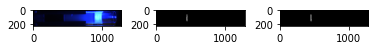

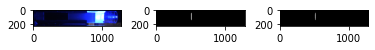

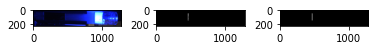

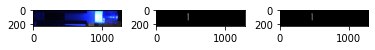

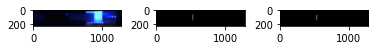

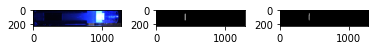

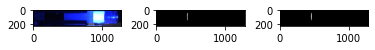

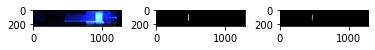

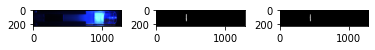

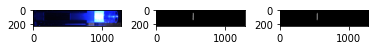

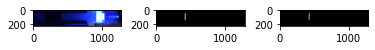

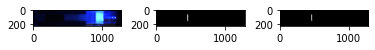

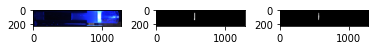

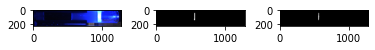

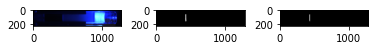

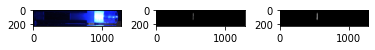

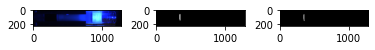

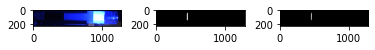

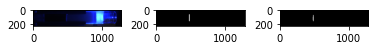

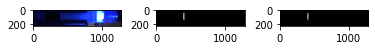

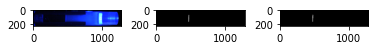

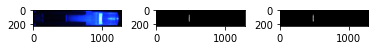

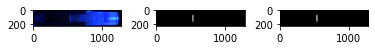

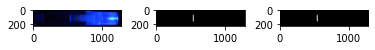

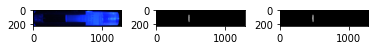

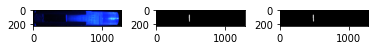

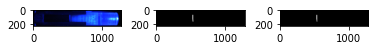

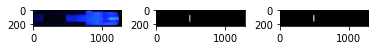

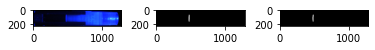

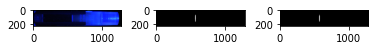

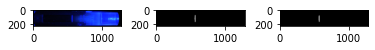

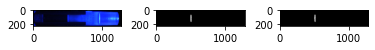

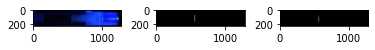

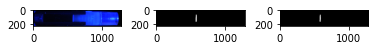

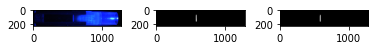

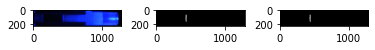

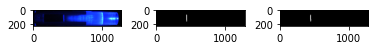

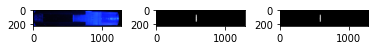

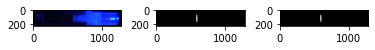

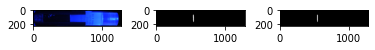

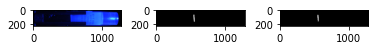

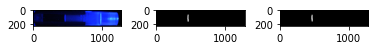

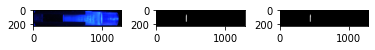

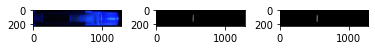

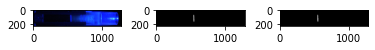

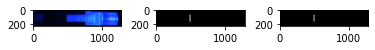

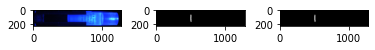

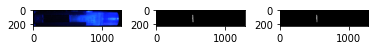

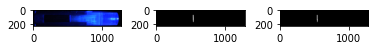

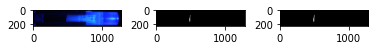

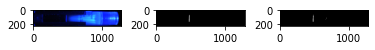

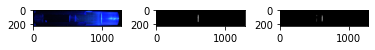

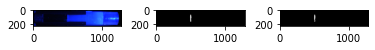

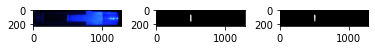

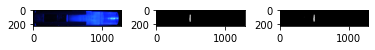

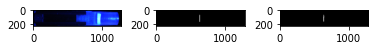

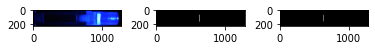

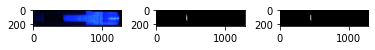

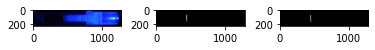

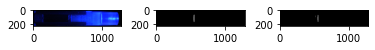

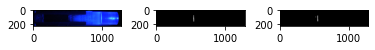

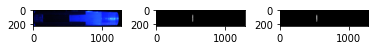

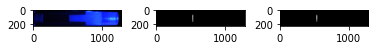

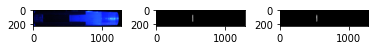

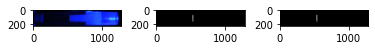

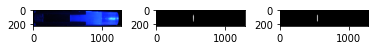

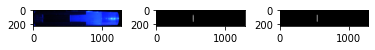

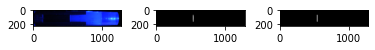

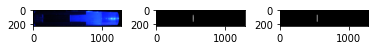

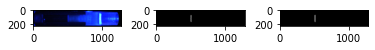

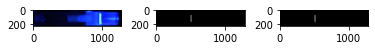

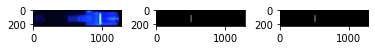

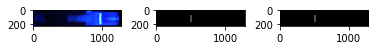

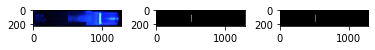

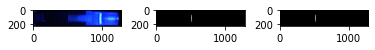

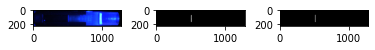

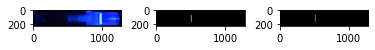

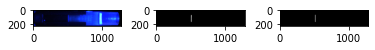

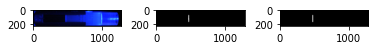

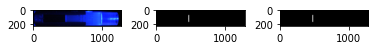

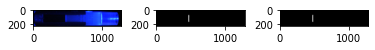

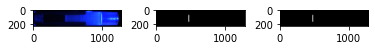

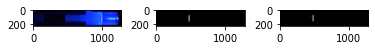

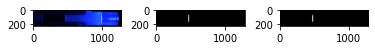

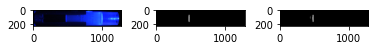

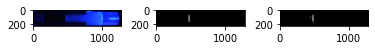

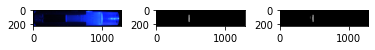

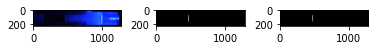

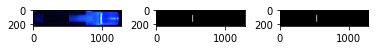

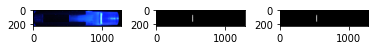

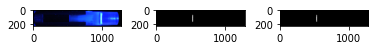

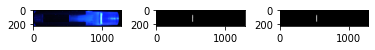

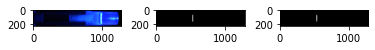

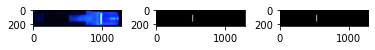

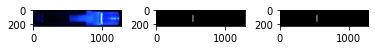

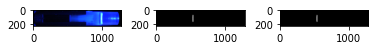

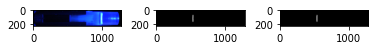

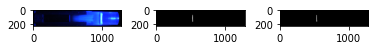

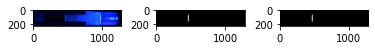

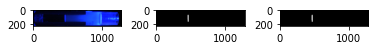

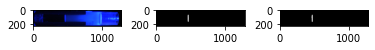

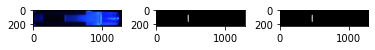

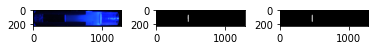

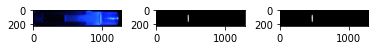

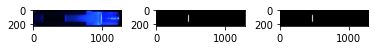

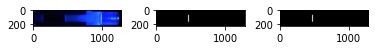

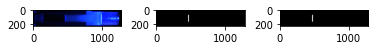

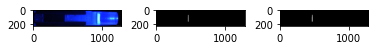

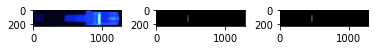

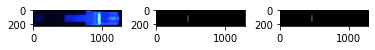

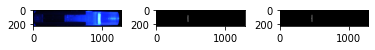

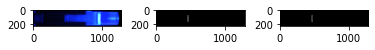

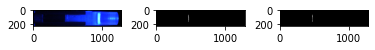

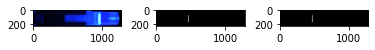

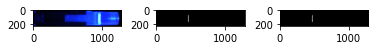

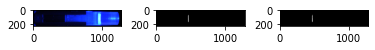

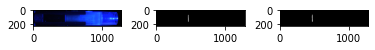

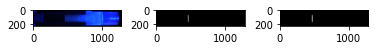

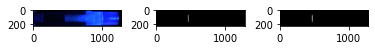

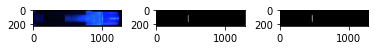

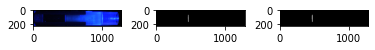

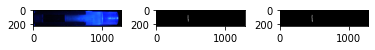

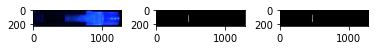

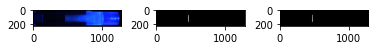

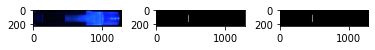

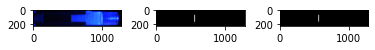

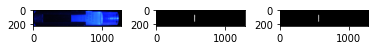

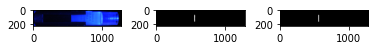

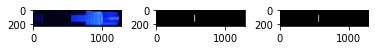

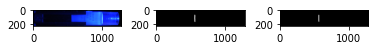

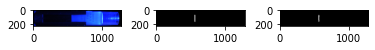

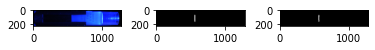

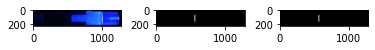

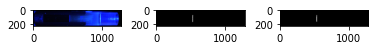

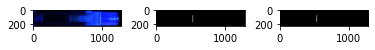

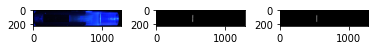

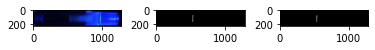

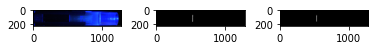

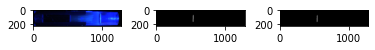

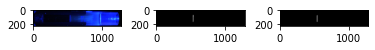

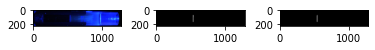

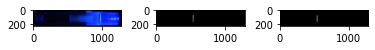

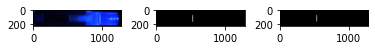

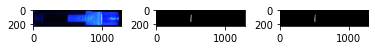

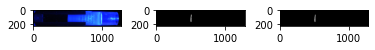

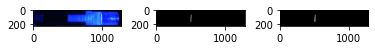

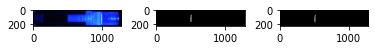

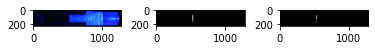

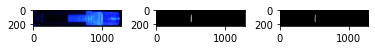

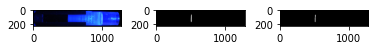

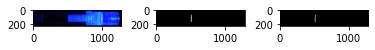

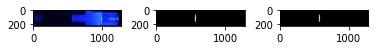

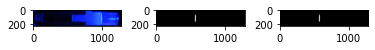

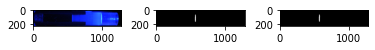

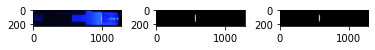

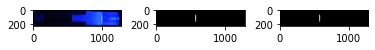

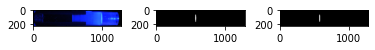

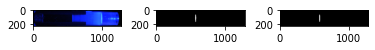

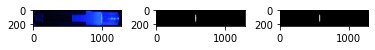

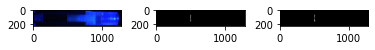

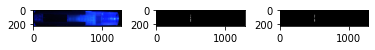

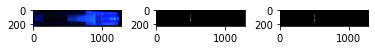

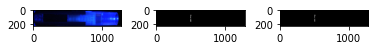

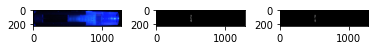

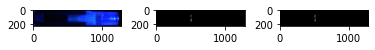

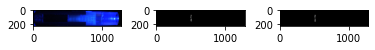

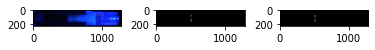

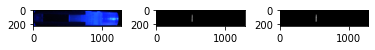

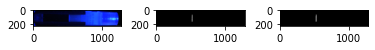

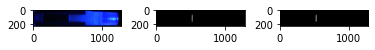

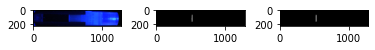

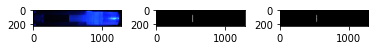

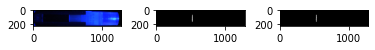

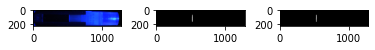

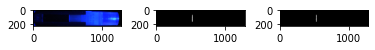

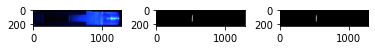

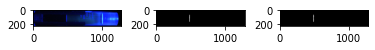

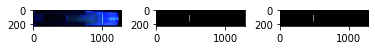

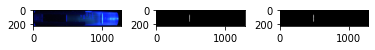

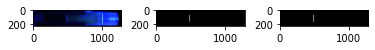

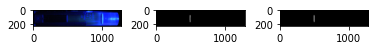

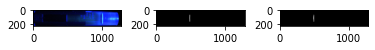

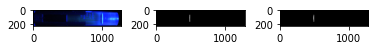

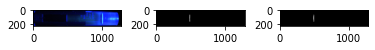

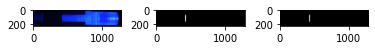

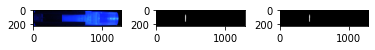

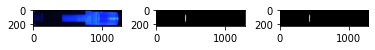

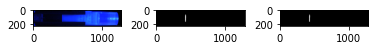

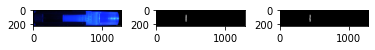

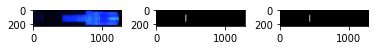

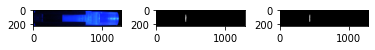

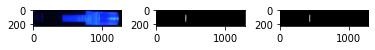

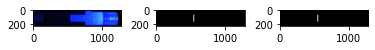

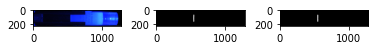

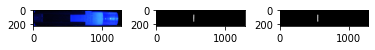

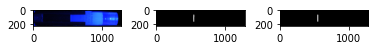

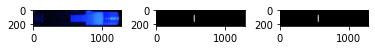

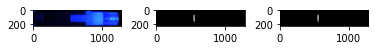

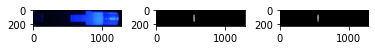

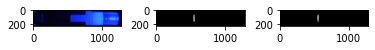

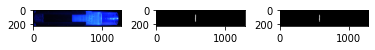

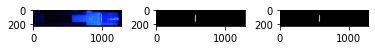

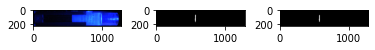

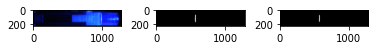

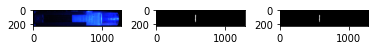

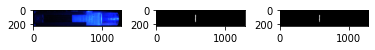

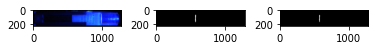

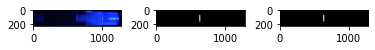

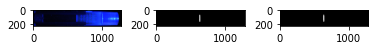

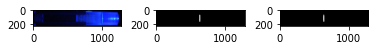

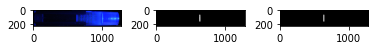

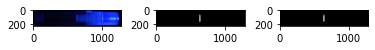

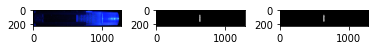

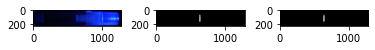

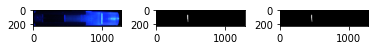

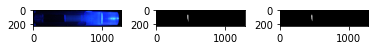

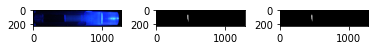

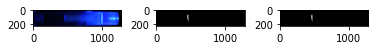

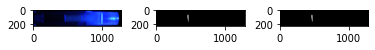

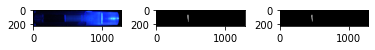

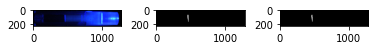

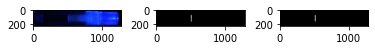

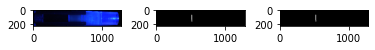

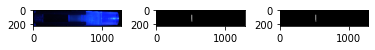

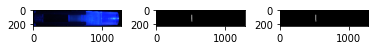

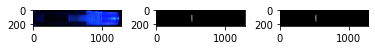

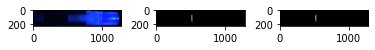

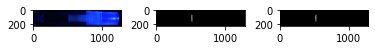

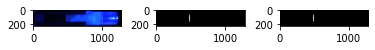

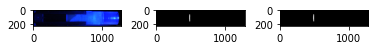

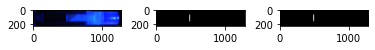

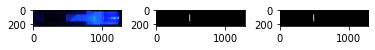

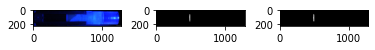

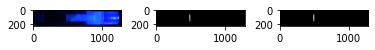

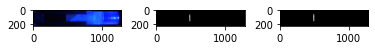

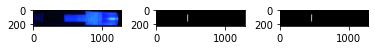

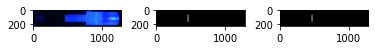

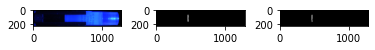

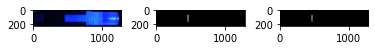

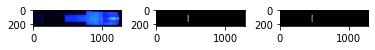

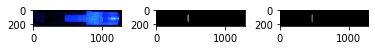

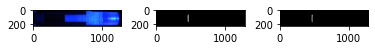

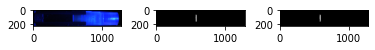

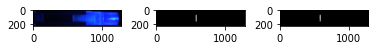

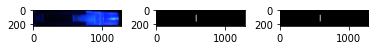

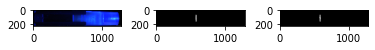

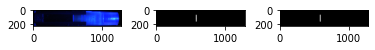

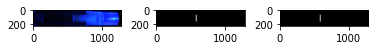

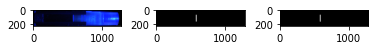

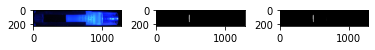

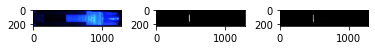

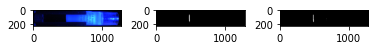

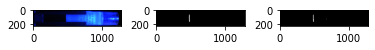

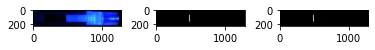

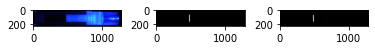

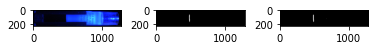

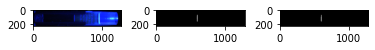

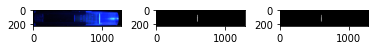

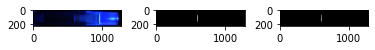

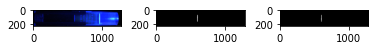

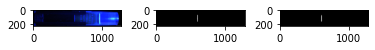

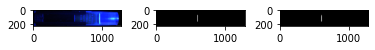

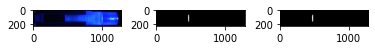

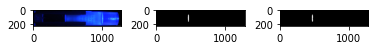

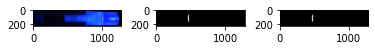

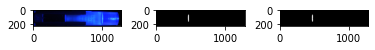

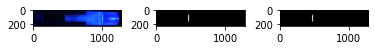

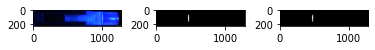

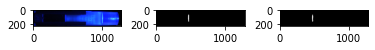

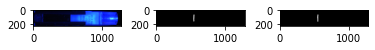

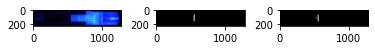

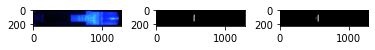

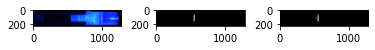

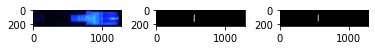

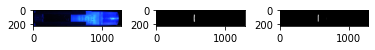

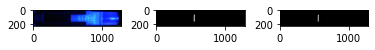

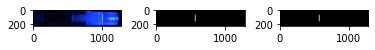

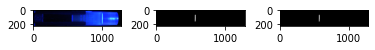

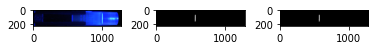

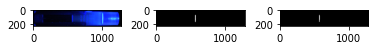

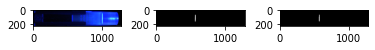

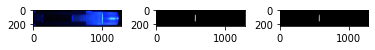

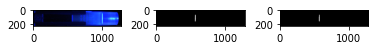

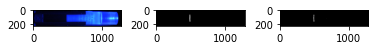

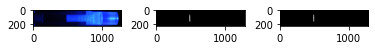

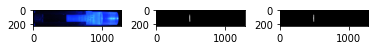

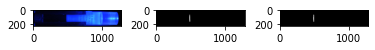

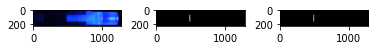

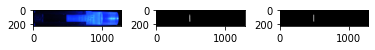

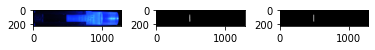

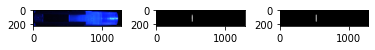

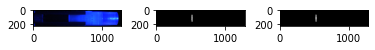

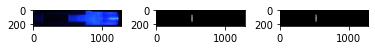

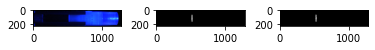

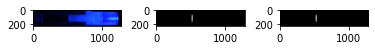

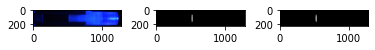

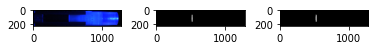

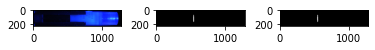

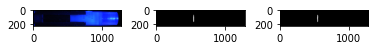

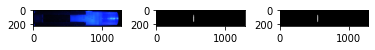

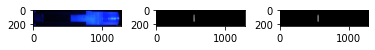

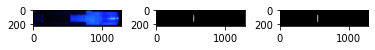

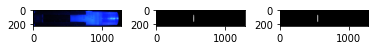

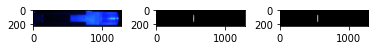

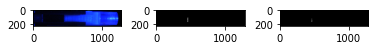

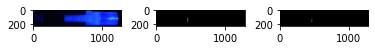

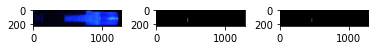

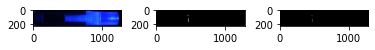

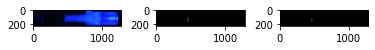

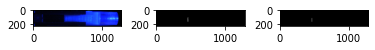

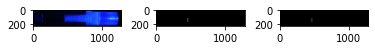

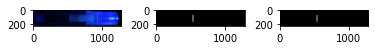

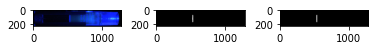

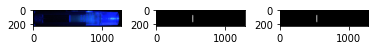

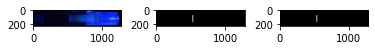

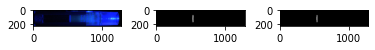

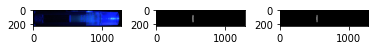

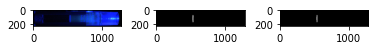

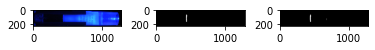

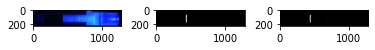

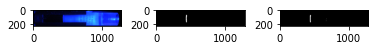

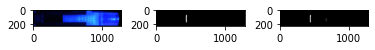

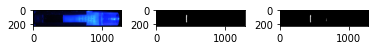

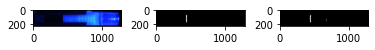

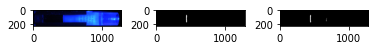

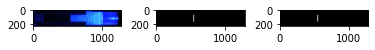

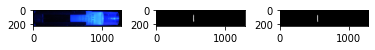

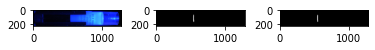

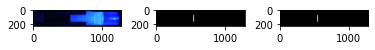

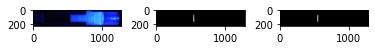

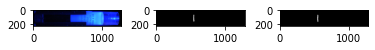

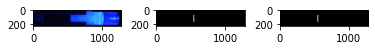

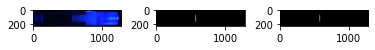

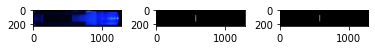

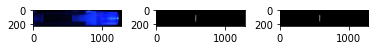

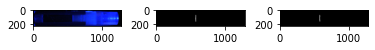

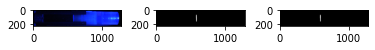

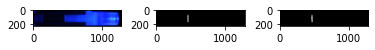

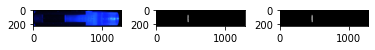

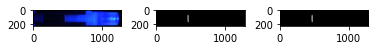

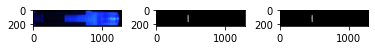

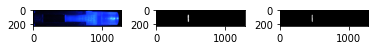

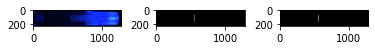

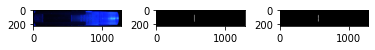

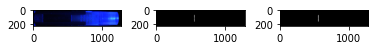

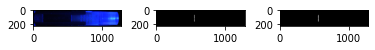

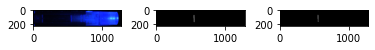

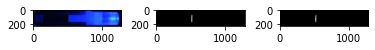

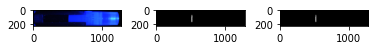

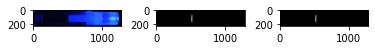

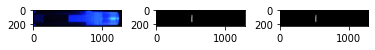

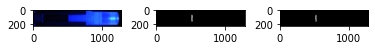

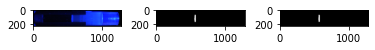

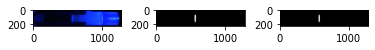

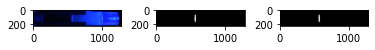

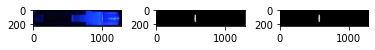

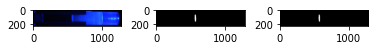

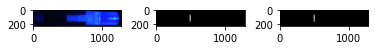

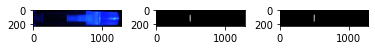

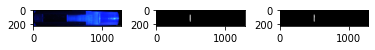

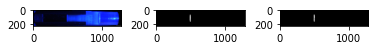

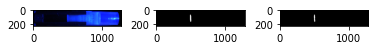

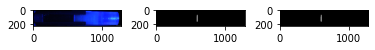

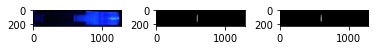

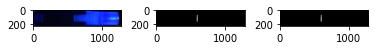

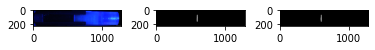

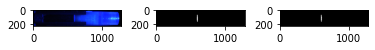

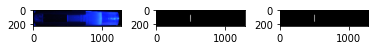

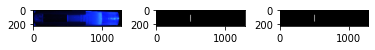

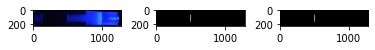

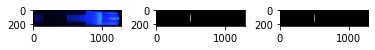

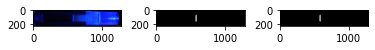

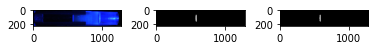

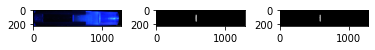

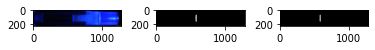

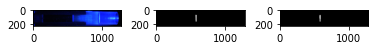

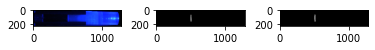

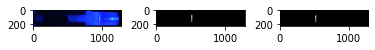

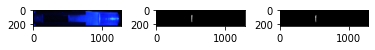

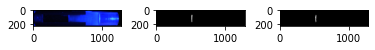

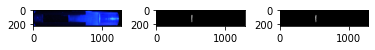

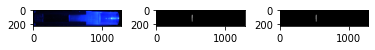

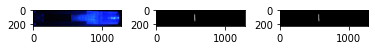

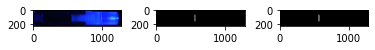

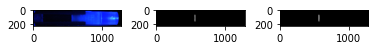

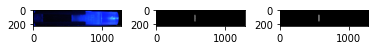

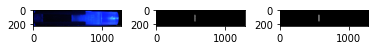

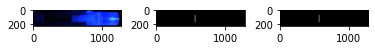

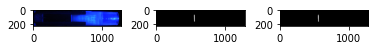

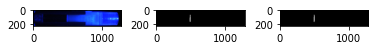

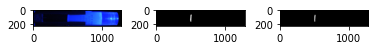

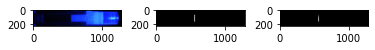

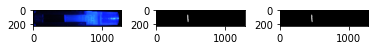

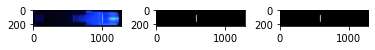

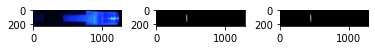

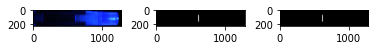

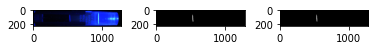

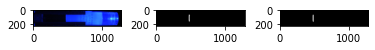

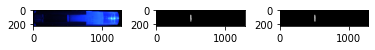

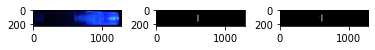

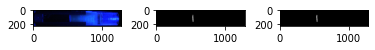

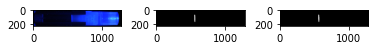

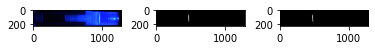

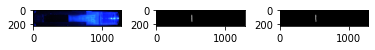

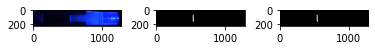

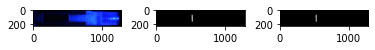

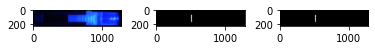

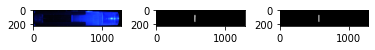

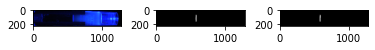

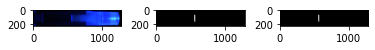

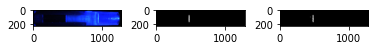

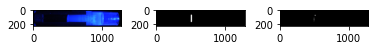

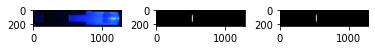

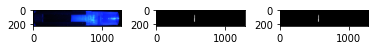

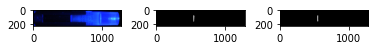

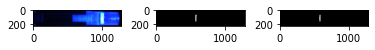

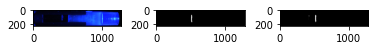

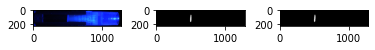

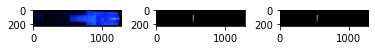

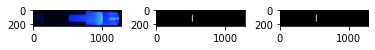

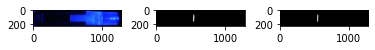

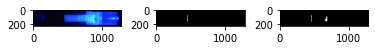

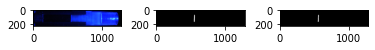

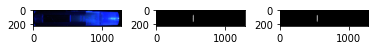

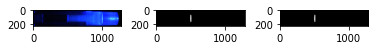

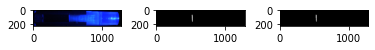

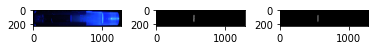

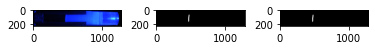

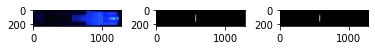

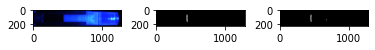

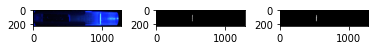

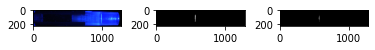

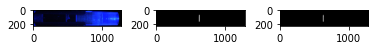

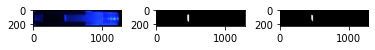

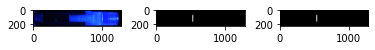

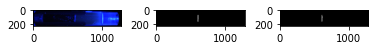

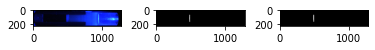

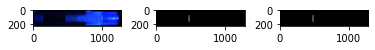

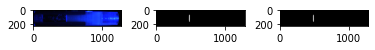

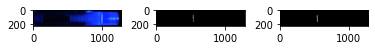

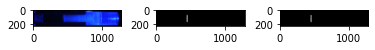

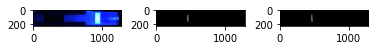

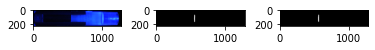

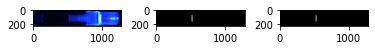

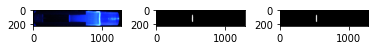

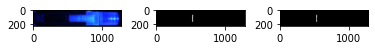

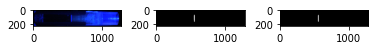

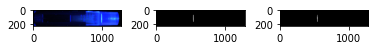

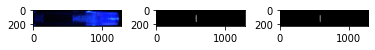

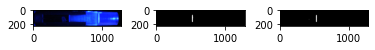

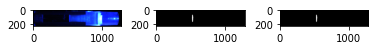

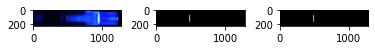

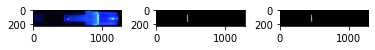

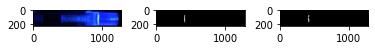

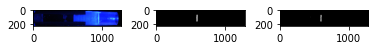

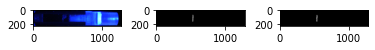

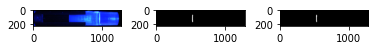

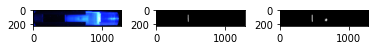

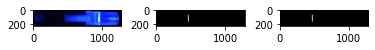

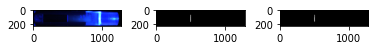

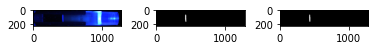

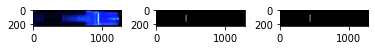

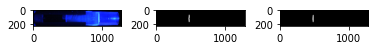

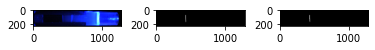

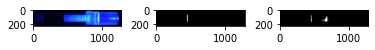

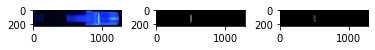

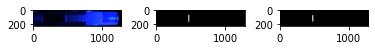

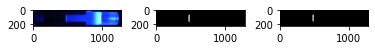

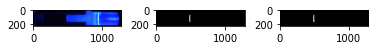

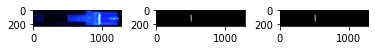

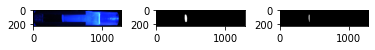

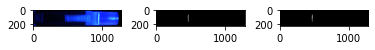

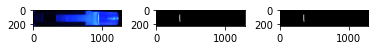

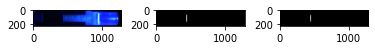

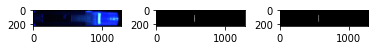

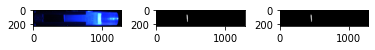

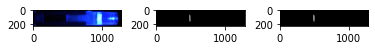

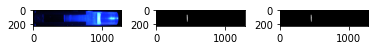

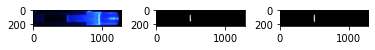

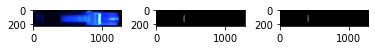

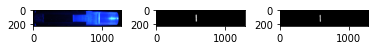

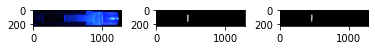

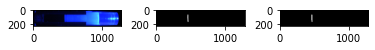

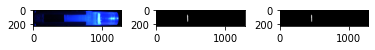

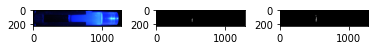

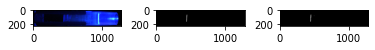

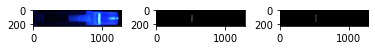

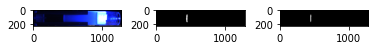

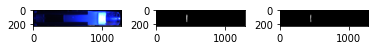

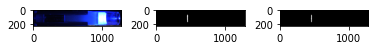

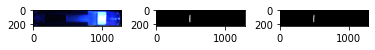

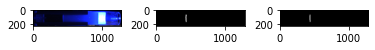

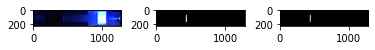

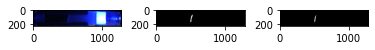

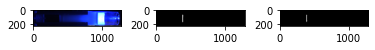

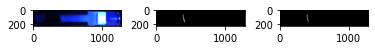

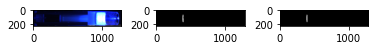

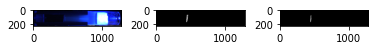

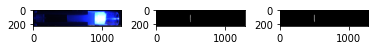

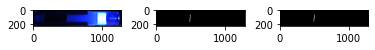

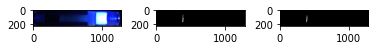

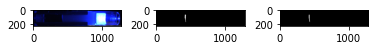

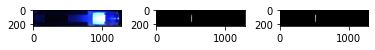

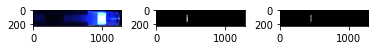

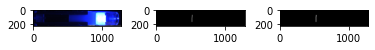

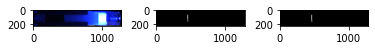

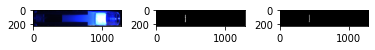

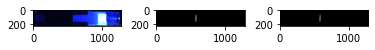

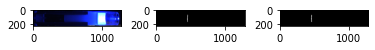

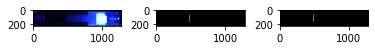

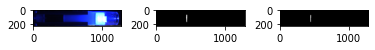

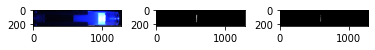

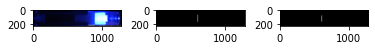

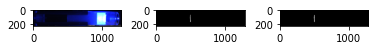

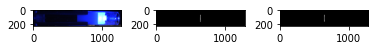

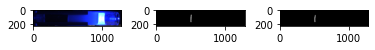

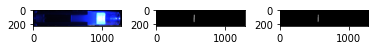

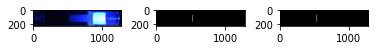

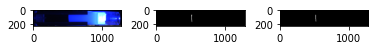

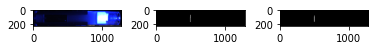

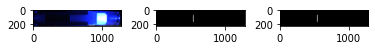

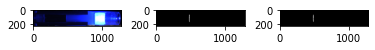

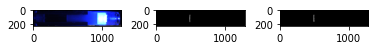

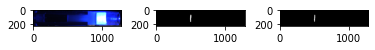

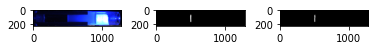

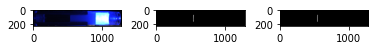

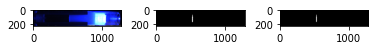

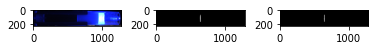

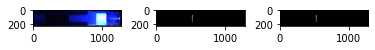

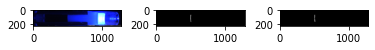

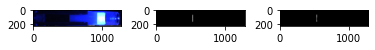

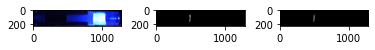

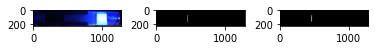

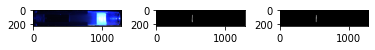

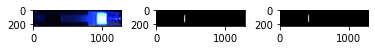

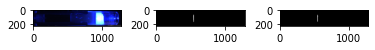

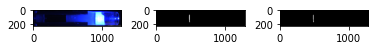

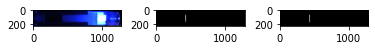

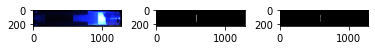

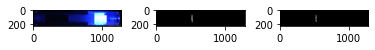

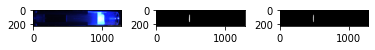

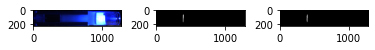

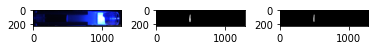

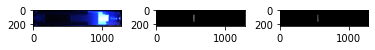

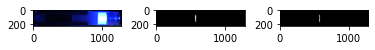

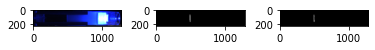

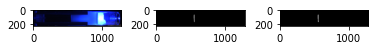

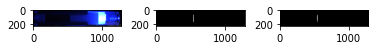

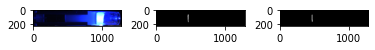

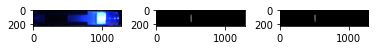

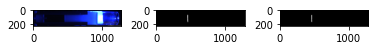

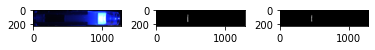

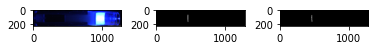

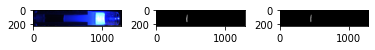

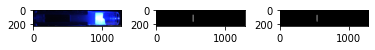

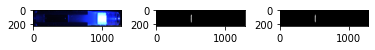

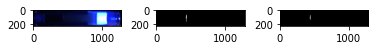

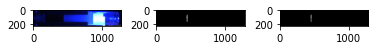

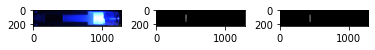

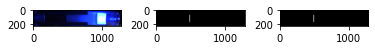

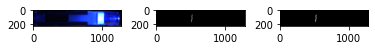

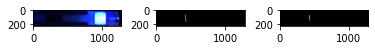

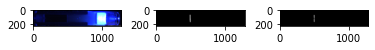

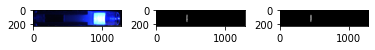

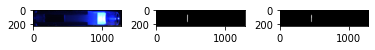

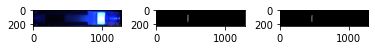

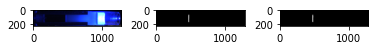

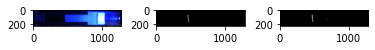

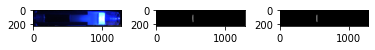

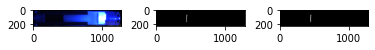

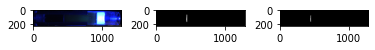

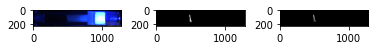

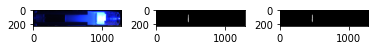

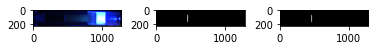

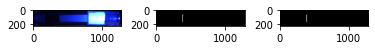

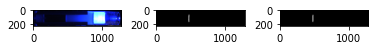

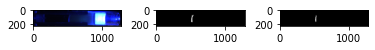

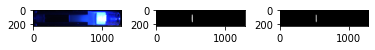

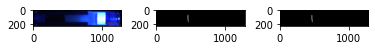

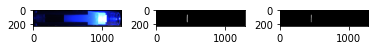

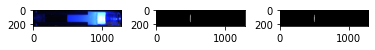

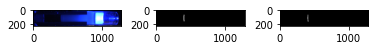

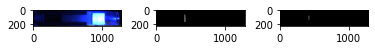

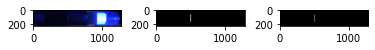

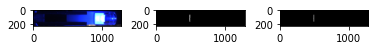

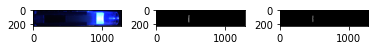

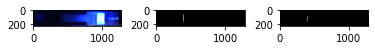

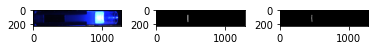

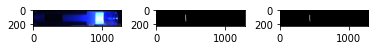

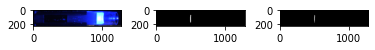

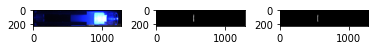

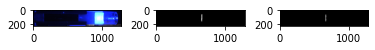

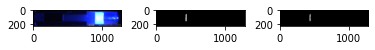

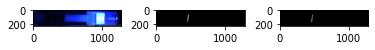

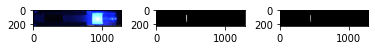

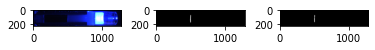

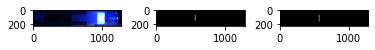

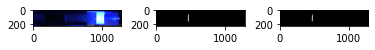

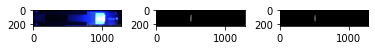

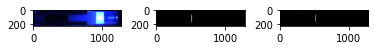

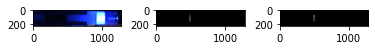

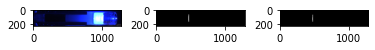

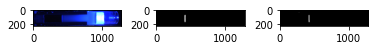

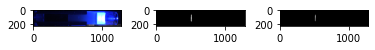

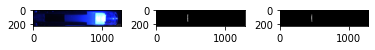

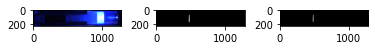

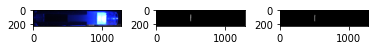

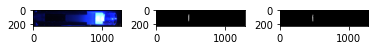

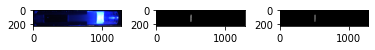

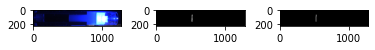

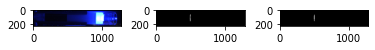

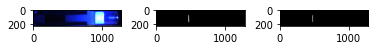

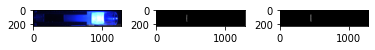

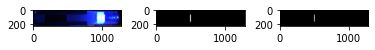

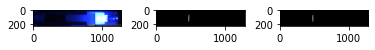

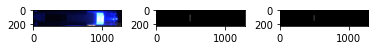

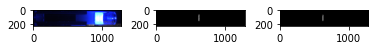

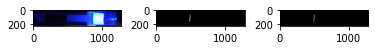

In [45]:
image_size = 224
m = random.randint(0, len(X_test)-1)

for i, item in df.iterrows():
        
    img = sitk.ReadImage(image_path + item[0]+'.png')
    img = sitk.GetArrayFromImage(img)/255.0
    display = img
    image = crop(img)
    image = cv.resize(image,(image_size,image_size))
    
    print(image.shape)
        
    mask = sitk.ReadImage(ground_path + item[0]+'_0_region.png')
    mask = sitk.GetArrayFromImage(mask)/255.0
    
    testing=np.expand_dims(image, axis=0)
    result= final_model.predict(testing)               # used to predict the result
    result=result>0.5
    predict_result =np.squeeze(result,axis=0)
    
    a= np.zeros((224,1280,1),dtype=np.uint8)
    m = predict_result.astype(np.uint8)
    dim = (500,200)
    resized = cv.resize(m,dim,interpolation = cv.INTER_AREA)
    resized = np.expand_dims(resized,axis= -1)
    a [0:200,200:700,:] = resized
    io.imsave(f'D:/Blood_4/Output/{item[0]}_output.png',a*255)
    

    fig = plt.figure()                                # plotting the results
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    ax = fig.add_subplot(1, 3, 1)                     # the original validation image
    ax.imshow(img)

    ax = fig.add_subplot(1, 3, 2)                     # the ground truth provided
    ax.imshow(mask, cmap="gray")

    ax = fig.add_subplot(1, 3, 3)                     # segmentation predicted by our neural net model
    ax.imshow(a*255, cmap="gray")

In [16]:
image_size = 224
m = random.randint(0, len(X_test)-1)

for i, item in df.iterrows():
        
    img = sitk.ReadImage(image_path + item[0]+'.png')
    img = sitk.GetArrayFromImage(img)/255.0
    display = img
    image = crop(img)
    image = cv.resize(image,(image_size,image_size))
    
    print(image.shape)
        
    mask = sitk.ReadImage(ground_path + item[0]+'_0_region.png')
    mask = sitk.GetArrayFromImage(mask)/255.0
    #mask2 = cv.cvtColor(mask, cv.GRAYSCALE)
    #ola = np.squeeze(mask,axis=-1)
    
    print(mask.shape)
    #retval=cv.countNonZero(mask)
    #print(retval)

    
    testing=np.expand_dims(image, axis=0)
    result= final_model.predict(testing)               # used to predict the result
    result=result>0.5
    predict_result =np.squeeze(result,axis=0)
    
    a= np.zeros((224,1280,1),dtype=np.uint8)
    m = predict_result.astype(np.uint8)
    dim = (500,200)
    resized = cv.resize(m,dim,interpolation = cv.INTER_AREA)
    resized = np.expand_dims(resized,axis= -1)
    a [0:200,200:700,:] = resized
    segment = a*255
    print(segment.shape)
    retval=cv.countNonZero(segment)
    print(retval)
    segment2 = cv.merge((segment,segment,segment))
    
    
    img_concate_Verti=np.concatenate((img,mask,segment2),axis=0)
    cv.imshow('concatenated_Verti',img_concate_Verti)
    
    if cv.waitKey(0) == ord('q'):
        break
cv.destroyAllWindows()

(224, 224, 3)
(224, 1280, 3)
(224, 1280, 1)
882
(224, 224, 3)
(224, 1280, 3)
(224, 1280, 1)
707
(224, 224, 3)
(224, 1280, 3)
(224, 1280, 1)
645
(224, 224, 3)
(224, 1280, 3)
(224, 1280, 1)
670
(224, 224, 3)
(224, 1280, 3)
(224, 1280, 1)
482
(224, 224, 3)
(224, 1280, 3)
(224, 1280, 1)
851
(224, 224, 3)
(224, 1280, 3)
(224, 1280, 1)
903


In [17]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

In [19]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tf_lite_converter.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\ASARKA~1.NAT\AppData\Local\Temp\tmpoxj4rre1\assets


In [20]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

16355920

In [21]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [  1 224 224   1]
Output Type: <class 'numpy.float32'>


In [22]:
X_test.dtype

dtype('float64')

In [23]:
input_data = np.float32(X_test)

In [16]:
interpreter = tf.lite.Interpreter(model_path="tf_lite_model.tflite")
interpreter.allocate_tensors()

In [17]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

[{'name': 'input_2', 'index': 0, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 442, 'shape': array([  1, 224, 224,   1]), 'shape_signature': array([ -1, 224, 224,   1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [  1 224 224   1]
Output Type: <class 'numpy.float32'>


In [18]:
y_test.shape

(124, 224, 224, 1)

In [19]:
image_size=224

img1 = sitk.ReadImage('a.png')
img1 = sitk.GetArrayFromImage(img1)/255.0
image = crop(img1)
image = cv.resize(image,(image_size,image_size))
image_data = np.array(image, dtype=np.float32)

testing=np.expand_dims(image_data, axis=0)

In [20]:
testing.shape

(1, 224, 224, 3)

In [21]:
testing.dtype

dtype('float32')

In [ ]:
interpreter.set_tensor(input_details[0]['index'], testing)
interpreter.invoke()

In [ ]:
raw_predictions = interpreter.tensor(interpreter.get_output_details()[0]['index'])()
seg_map = tf.argmax(tf.image.resize(raw_prediction, (224,224)), axis=3)
seg_map = tf.squeeze(seg_map).numpy().astype(np.int8)
print("Prediction results shape:", seg_map.shape)

plt.imshow(seg_map)

In [ ]:
image_size=224

for i, item in df.iterrows():
        
    img = sitk.ReadImage(image_path + item[0]+'.png')
    img = sitk.GetArrayFromImage(img)/255.0
    display = img
    image = crop(img)
    image = cv.resize(image,(image_size,image_size))
    image_data = np.array(image, dtype=np.float32)
    print(image_data.shape)
        
    mask = sitk.ReadImage(ground_path + item[0]+'_0_region.png')
    mask = sitk.GetArrayFromImage(mask)/255.0
    
    print(mask.shape)
    
    testing=np.expand_dims(image_data, axis=0)
    
    print(testing.shape)

    interpreter.set_tensor(input_details[0]['index'], testing)
    interpreter.invoke()
    
    tflite_model_predictions = interpreter.tensor(interpreter.get_output_details()[0]['index'])()
    print("Prediction results shape:", tflite_model_predictions.shape)
    
    seg_map = tf.argmax(tf.image.resize(raw_prediction, (224,224)), axis=3)
    seg_map = tf.squeeze(seg_map).numpy().astype(np.int8)
    
    
    a= np.zeros((224,1280,1),dtype=np.uint8)
    m = seg_map.astype(np.uint8)
    dim = (500,200)
    resized = cv.resize(m,dim,interpolation = cv.INTER_AREA)
    resized = np.expand_dims(resized,axis= -1)
    a [0:200,200:700,:] = resized
    segment = a*255
    print(segment.shape)
    retval=cv.countNonZero(segment)
    print(retval)
    segment2 = cv.merge((segment,segment,segment))
    
    fig = plt.figure()                                # plotting the results
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    ax = fig.add_subplot(1, 3, 1)                     # the original validation image
    ax.imshow(img)

    ax = fig.add_subplot(1, 3, 2)                     # the ground truth provided
    ax.imshow(mask, cmap="gray")

    ax = fig.add_subplot(1, 3, 3)                     # segmentation predicted by our neural net model
    ax.imshow(segment, cmap="gray")
    
    break
    #img_concate_Verti=np.concatenate((img,mask,segment2),axis=0)
    #cv.imshow('concatenated_Verti',img_concate_Verti)
    
    #if cv.waitKey(0) == ord('q'):
        #break
#cv.destroyAllWindows()

(224, 224, 3)
(224, 1280, 3)
(1, 224, 224, 3)
